In [1]:
# bayes classifier over emotion dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from lib.dataset_utils import *
from sklearn.pipeline import Pipeline
from lib.plot_utils import plot_multilabel_confusion_heatmap, plot_score_barplot
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import os
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
import string

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
DATASET = DatasetEnum.GoEmotionsCleaned
# load dataset
train_df, val_df, test_df = load_dataset(DATASET)
LABELS = train_df.columns[1:]
TEXT_COLUMN = 'text'

In [3]:
def bayes_analysis(train_df, val_df, classifier, text_col, label_cols):
    # train classifier
    classifier.fit(train_df[text_col], train_df[label_cols])
    # predict
    predictions_train = classifier.predict(train_df[text_col])
    predictions_val = classifier.predict(val_df[text_col])
    # calculate metrics
    print("Train metrics")
    print(classification_report(train_df[label_cols], predictions_train, target_names=label_cols, zero_division=0))
    print("Val metrics")
    print(classification_report(val_df[label_cols], predictions_val, target_names=label_cols, zero_division=0))
    # plot confusion matrix
    print("Train confusion matrix")
    plot_multilabel_confusion_heatmap(train_df[label_cols].to_numpy(), predictions_train, label_cols, label_cols, normalize=True)
    print("Val confusion matrix")
    plot_multilabel_confusion_heatmap(val_df[label_cols].to_numpy(), predictions_val, label_cols, label_cols, normalize=True)
    # bar plot over classes
    plot_score_barplot(train_df[label_cols], predictions_train, label_cols)
    plot_score_barplot(val_df[label_cols], predictions_val, label_cols)

In [7]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
def clean_content(text):
    # tokenize
    clean_text = nltk.word_tokenize(text)
    
    # pos tag
    clean_text = nltk.pos_tag(clean_text)
    TAG_MAP = {'N': 'n', 'V': 'v', 'R': 'r', 'J': 'a'}
    clean_text = [(word, TAG_MAP.get(tag[0], 'n')) for word, tag in clean_text]

    # lemmatize
    clean_text = [lemmatizer.lemmatize(word, tag) for word, tag in clean_text]

    # remove punctuation marks
    clean_text = [w for w in clean_text if w not in string.punctuation]

    return ' '.join(clean_text)

def clean_df(df, text_col, out_col):
    df[out_col] = df[text_col].apply(clean_content)
    return df

In [8]:
CLEAN_TEXT_COLUMN = 'clean_text'
train_df = clean_df(train_df, TEXT_COLUMN, CLEAN_TEXT_COLUMN)
val_df = clean_df(val_df, TEXT_COLUMN, CLEAN_TEXT_COLUMN)
test_df = clean_df(test_df, TEXT_COLUMN, CLEAN_TEXT_COLUMN)

Train metrics
                precision    recall  f1-score   support

    admiration       1.00      0.02      0.04      4130
     amusement       0.92      0.00      0.01      2328
   disapproval       0.00      0.00      0.00      2022
       disgust       0.00      0.00      0.00       793
 embarrassment       0.00      0.00      0.00       303
    excitement       0.00      0.00      0.00       853
          fear       0.00      0.00      0.00       596
     gratitude       1.00      0.09      0.17      2662
         grief       0.00      0.00      0.00        77
           joy       0.00      0.00      0.00      1452
          love       1.00      0.01      0.01      2086
   nervousness       0.00      0.00      0.00       164
         anger       1.00      0.00      0.00      1567
      optimism       0.00      0.00      0.00      1581
         pride       0.00      0.00      0.00       111
   realization       0.00      0.00      0.00      1110
        relief       0.00      0.

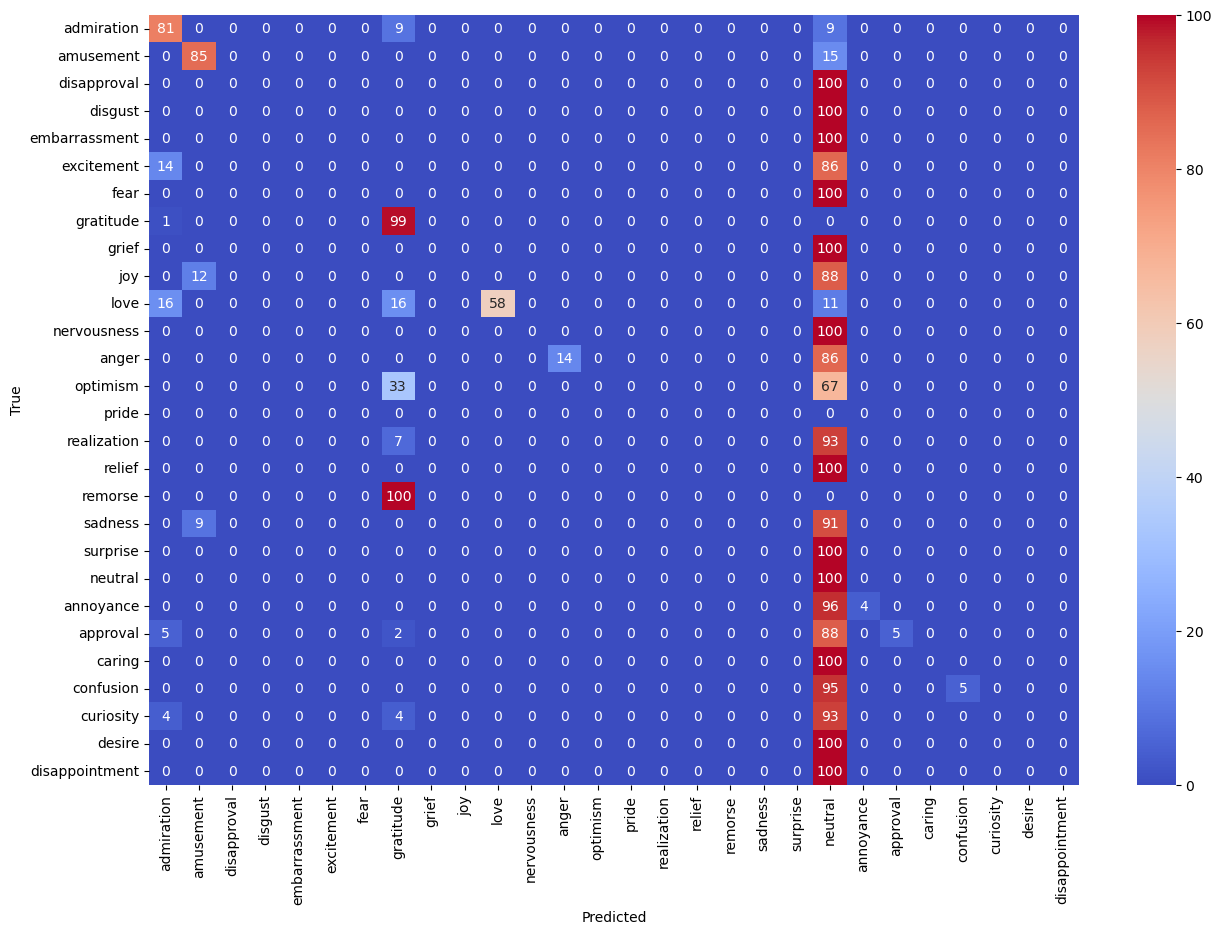

Val confusion matrix


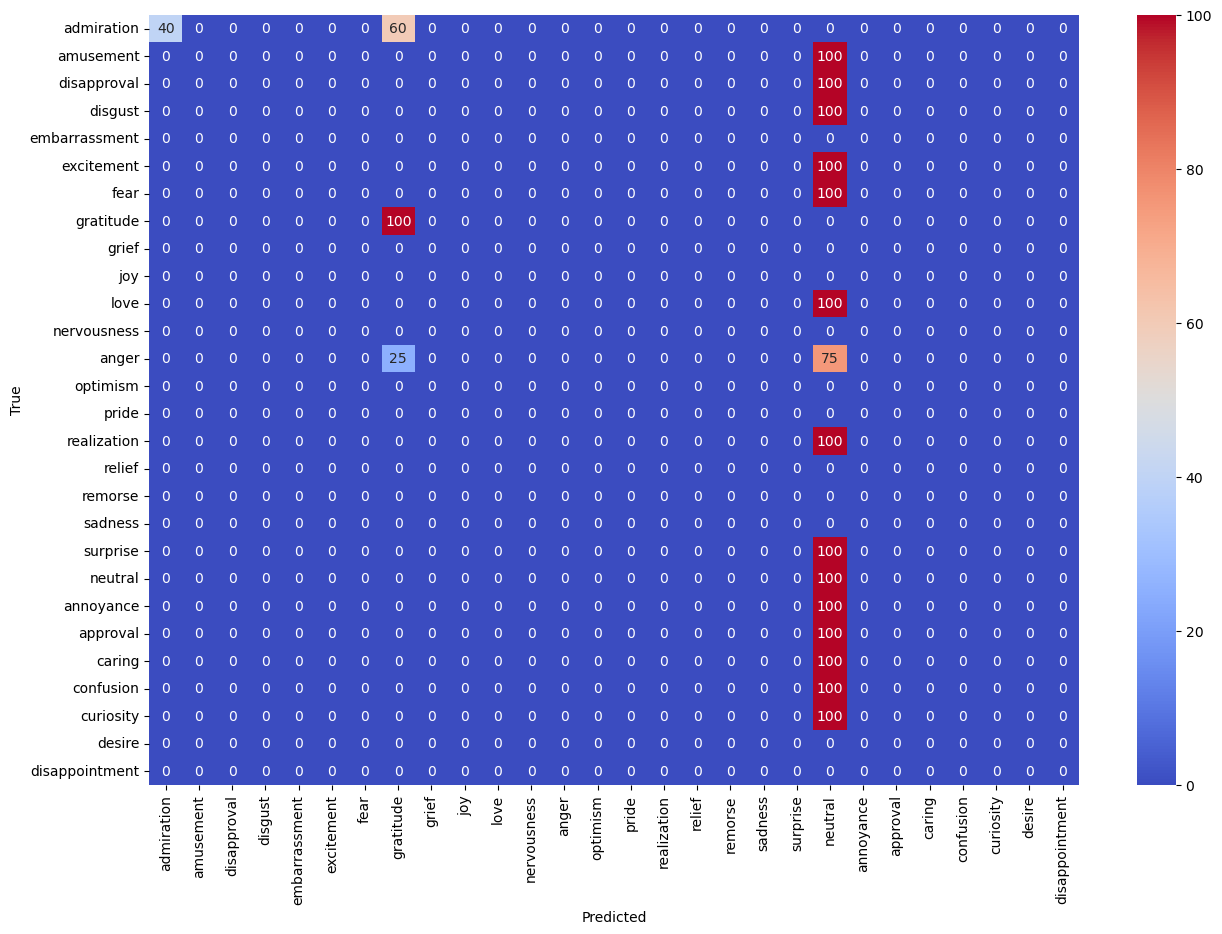

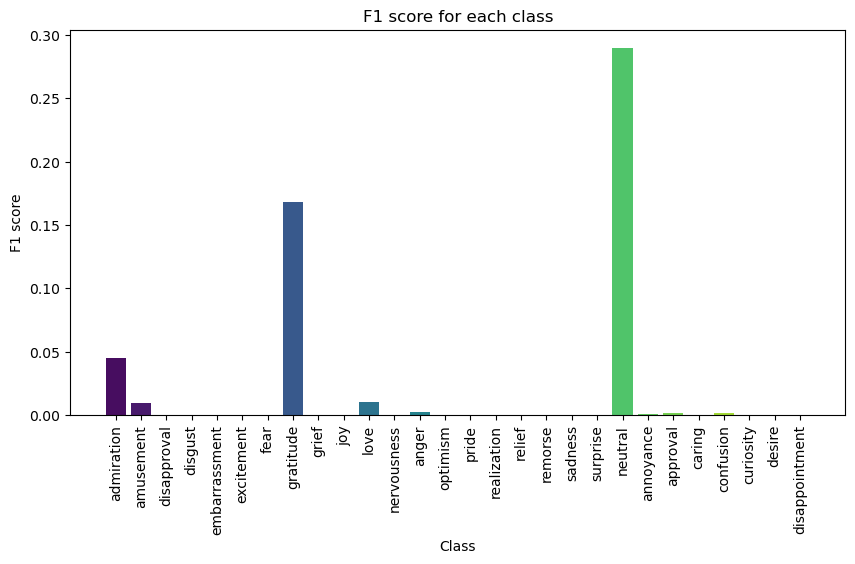

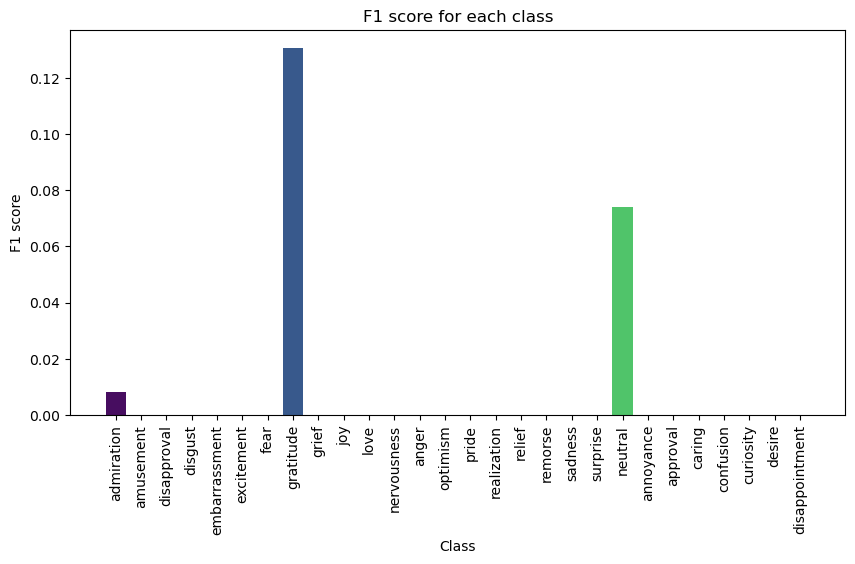

In [6]:
# training one versus rest classifier
NB_classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
]))

bayes_analysis(train_df, val_df, NB_classifier, TEXT_COLUMN, LABELS)

## Testing Bayes with normalized text

Train metrics
                precision    recall  f1-score   support

    admiration       0.95      0.05      0.09      4130
     amusement       0.90      0.02      0.04      2328
   disapproval       0.00      0.00      0.00      2022
       disgust       1.00      0.01      0.02       793
 embarrassment       0.00      0.00      0.00       303
    excitement       0.00      0.00      0.00       853
          fear       0.00      0.00      0.00       596
     gratitude       0.98      0.13      0.24      2662
         grief       0.00      0.00      0.00        77
           joy       0.00      0.00      0.00      1452
          love       1.00      0.00      0.01      2086
   nervousness       0.00      0.00      0.00       164
         anger       1.00      0.00      0.00      1567
      optimism       0.00      0.00      0.00      1581
         pride       0.00      0.00      0.00       111
   realization       0.00      0.00      0.00      1110
        relief       0.00      0.

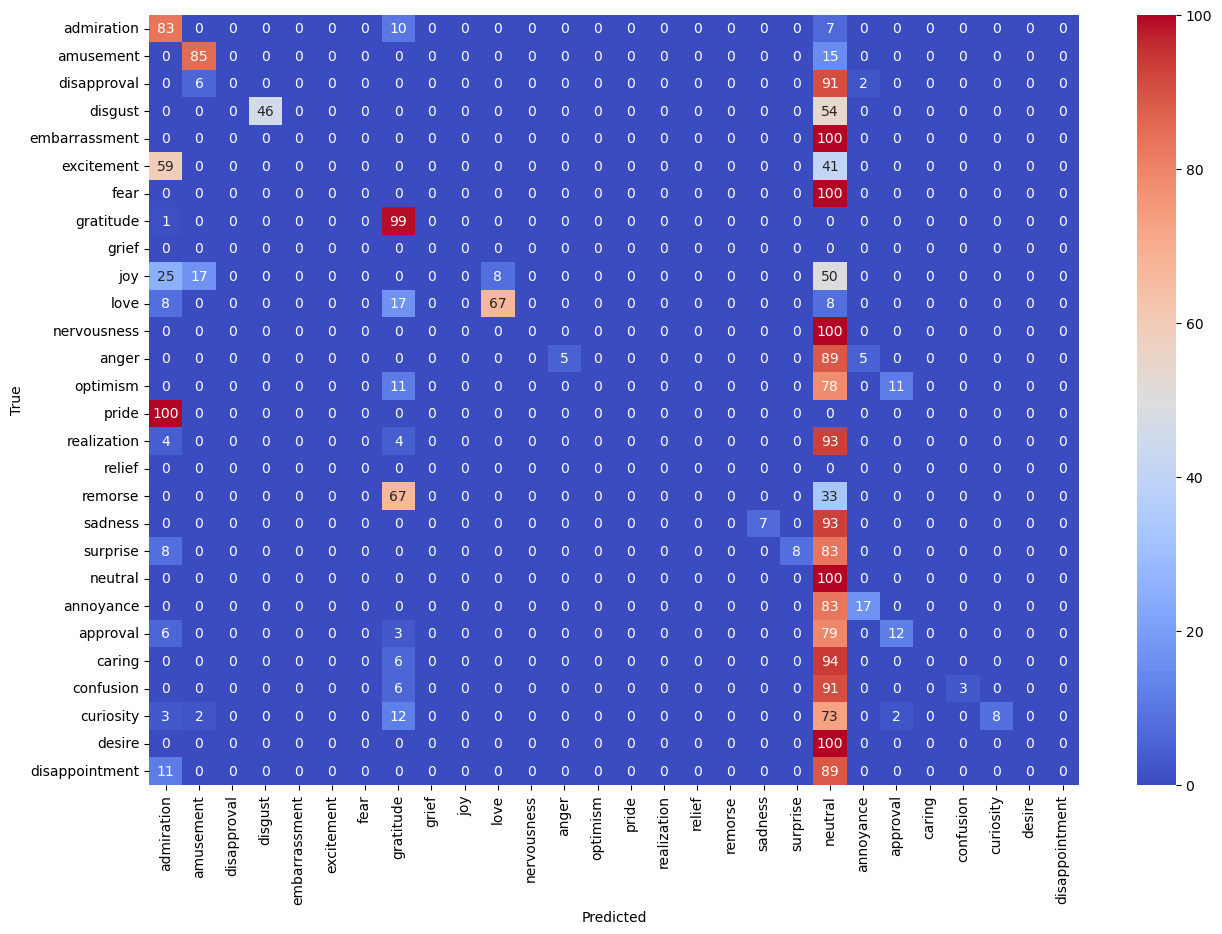

Val confusion matrix


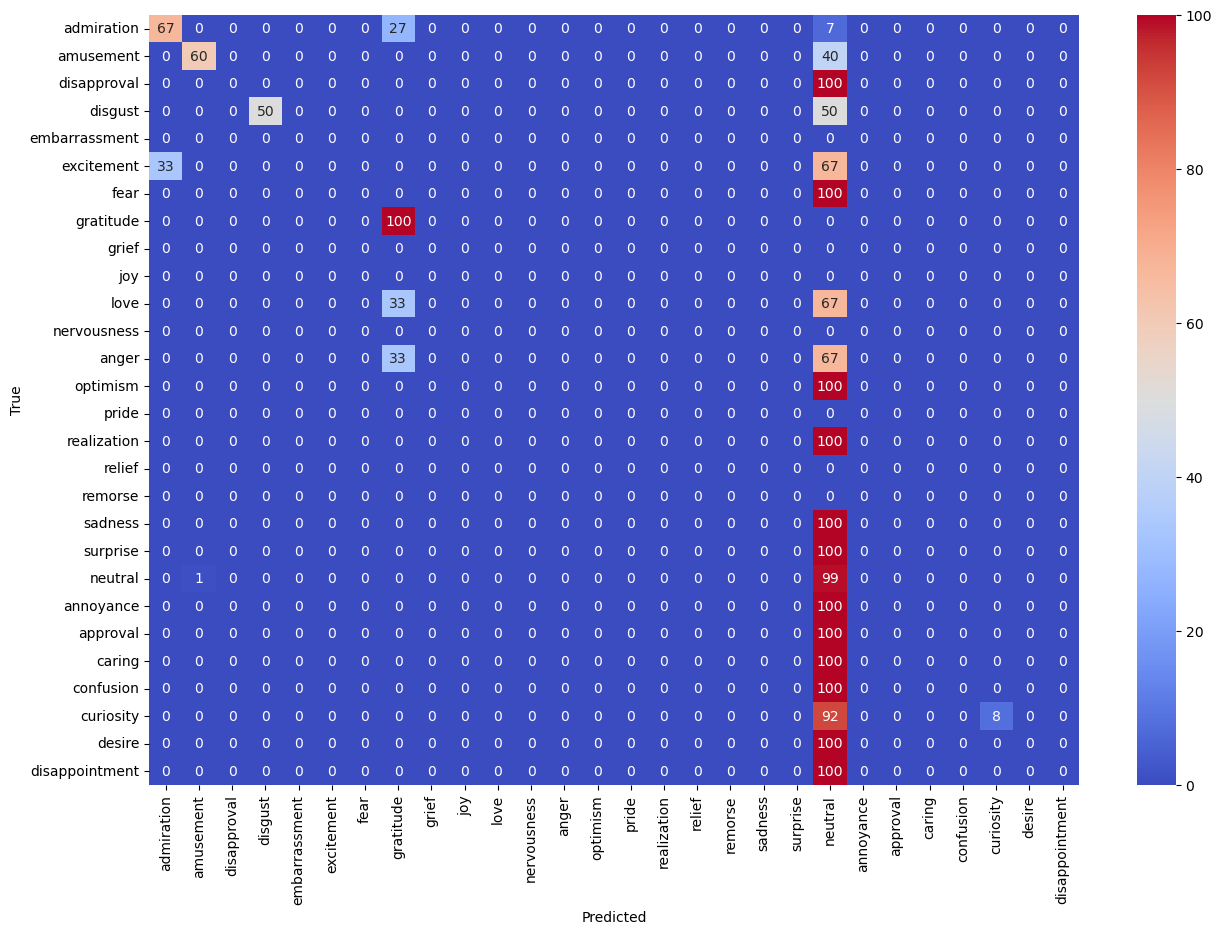

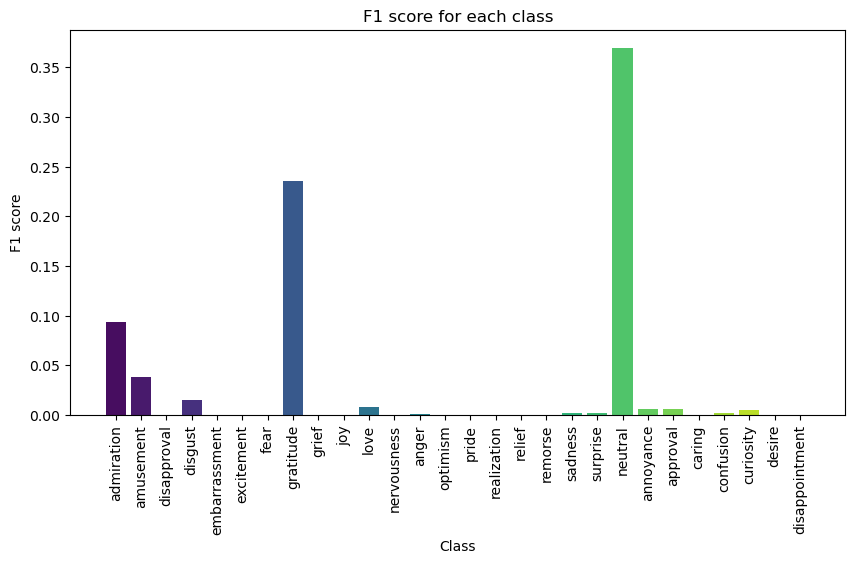

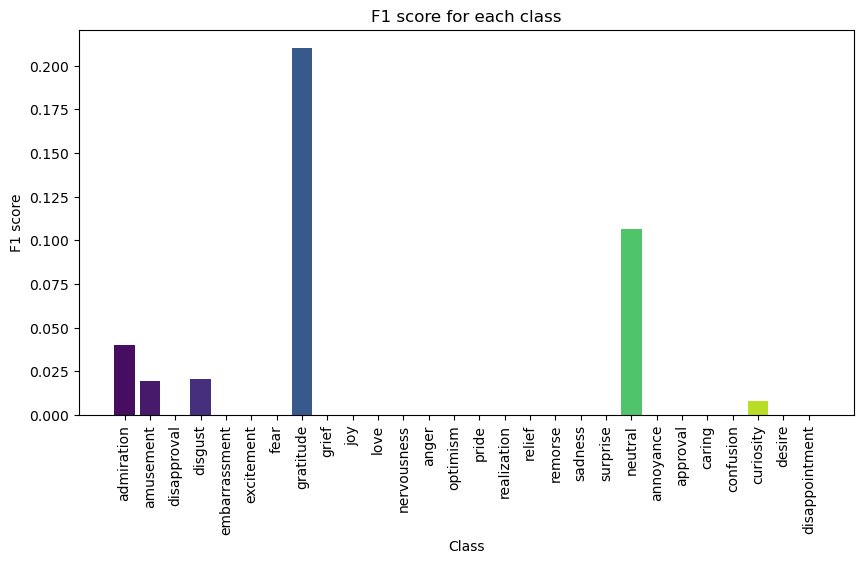

In [7]:
NB_classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', MultinomialNB())
]))
bayes_analysis(train_df, val_df, NB_classifier, CLEAN_TEXT_COLUMN, LABELS)

## Test add k

Train metrics
                precision    recall  f1-score   support

    admiration       0.97      0.36      0.52      4130
     amusement       0.96      0.27      0.42      2328
   disapproval       0.99      0.16      0.27      2022
       disgust       0.98      0.16      0.27       793
 embarrassment       1.00      0.08      0.15       303
    excitement       0.99      0.15      0.26       853
          fear       1.00      0.13      0.23       596
     gratitude       0.99      0.55      0.71      2662
         grief       0.00      0.00      0.00        77
           joy       0.88      0.17      0.28      1452
          love       0.98      0.28      0.44      2086
   nervousness       1.00      0.04      0.08       164
         anger       1.00      0.20      0.33      1567
      optimism       1.00      0.16      0.27      1581
         pride       1.00      0.03      0.05       111
   realization       1.00      0.09      0.17      1110
        relief       1.00      0.

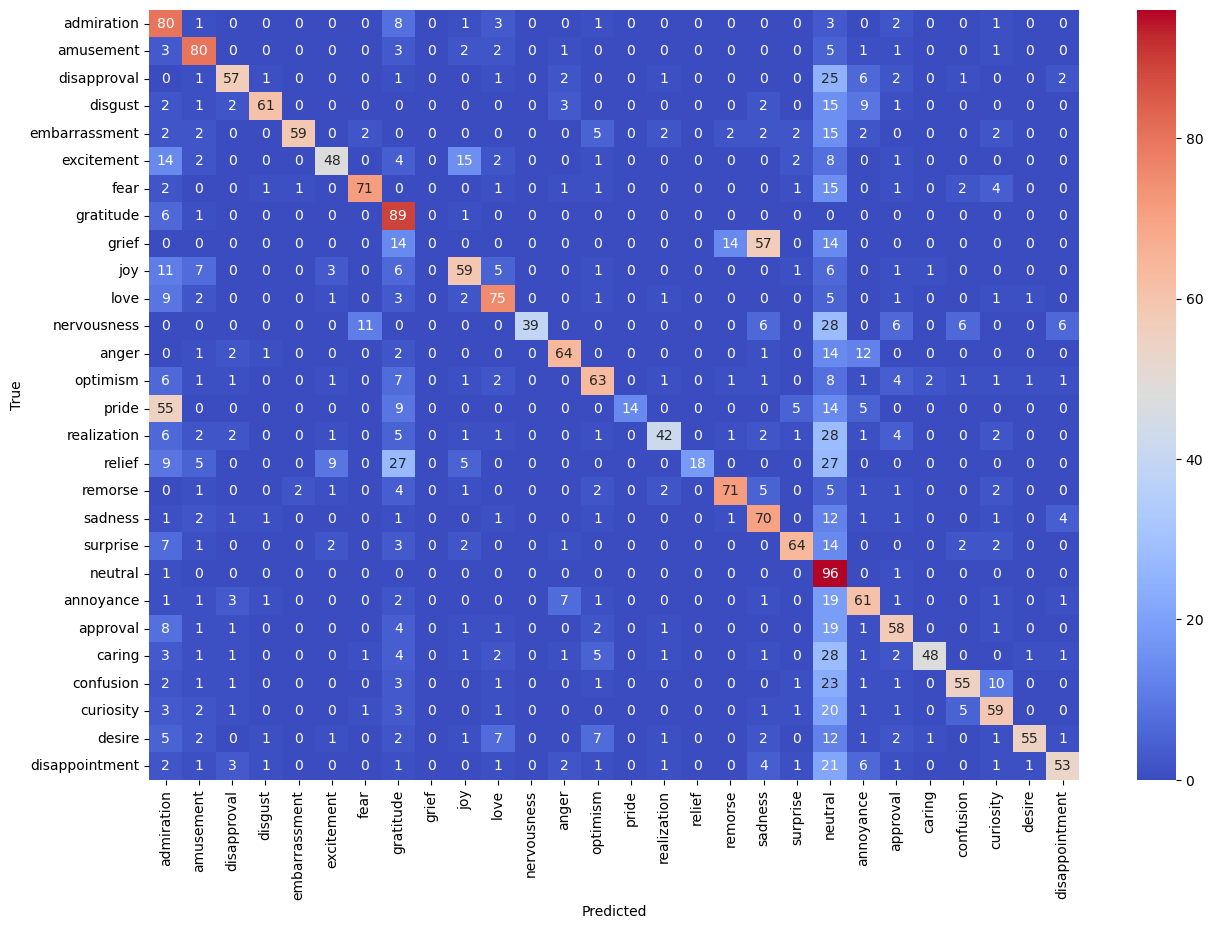

Val confusion matrix


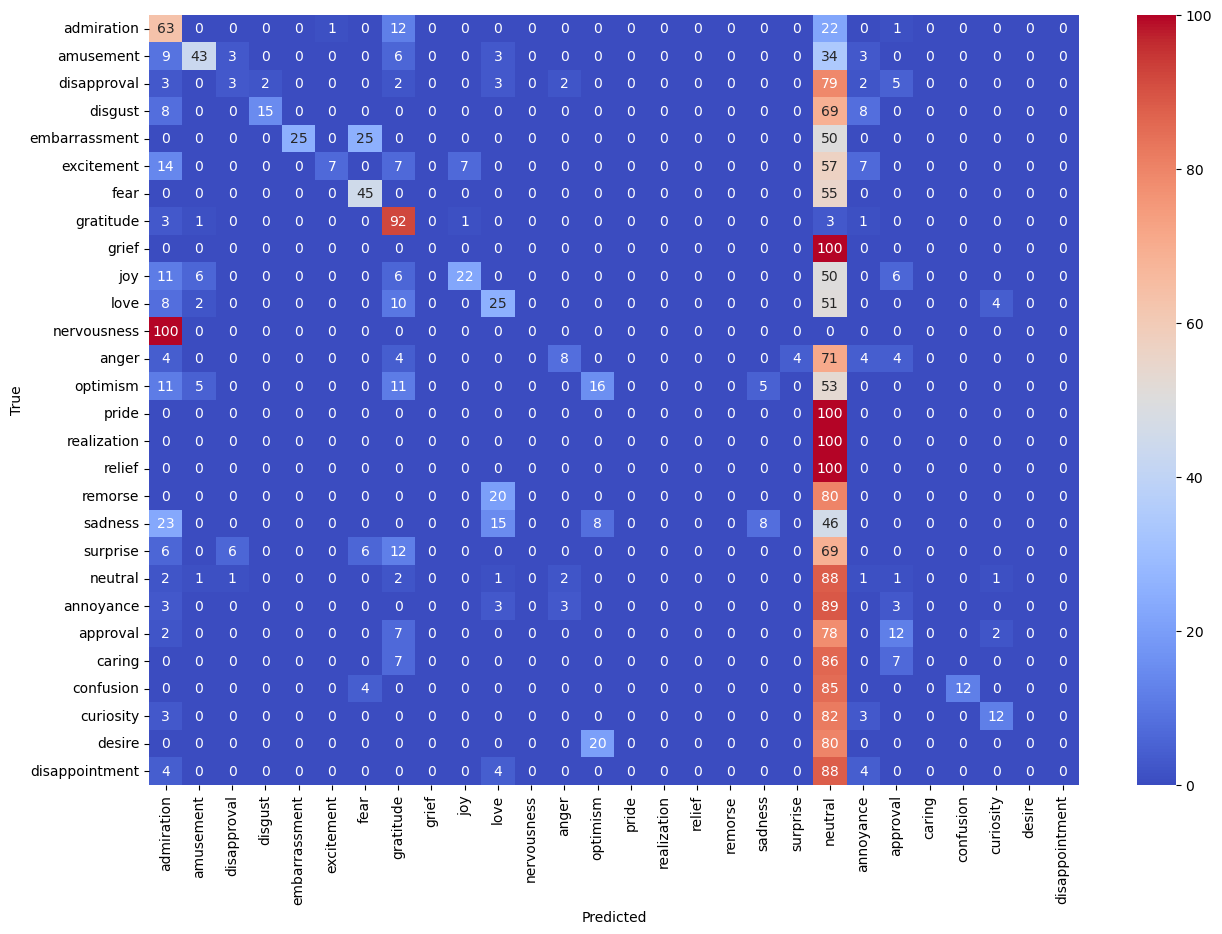

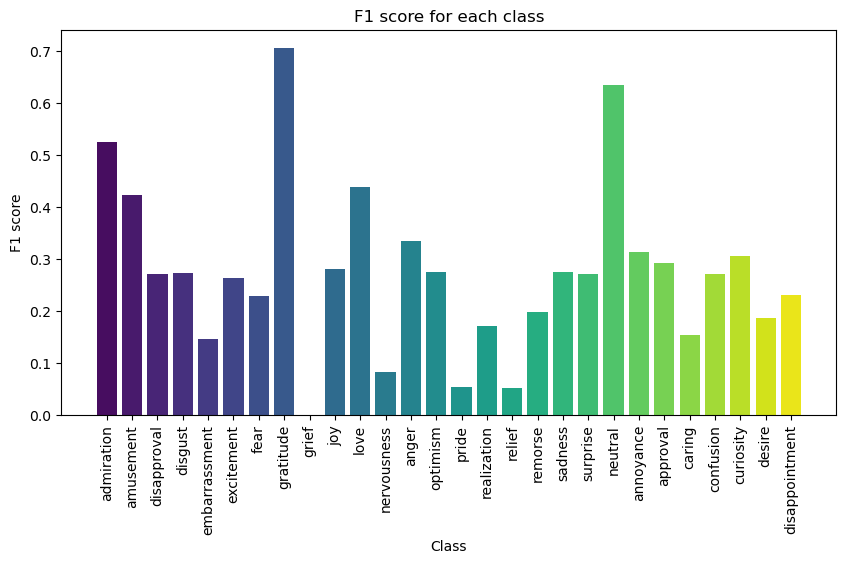

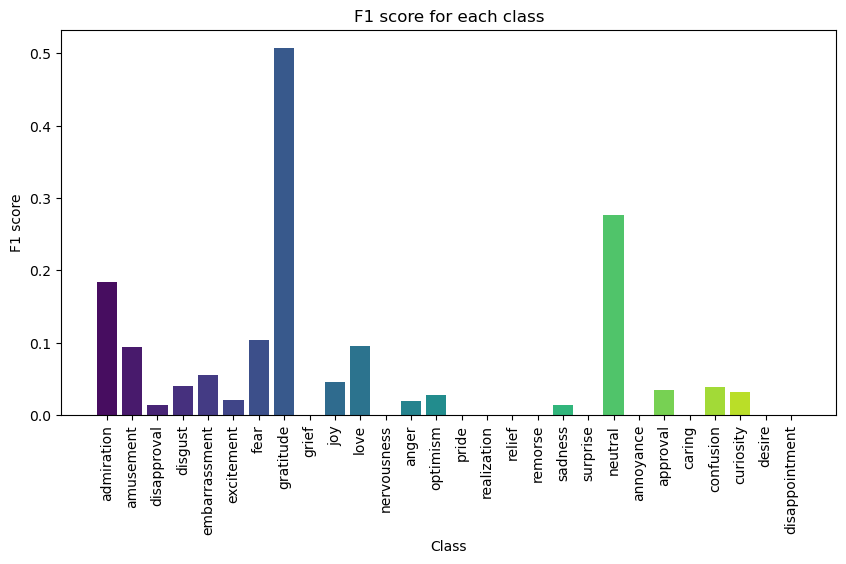

In [8]:
NB_classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', MultinomialNB(alpha=0.1))
]))
bayes_analysis(train_df, val_df, NB_classifier, CLEAN_TEXT_COLUMN, LABELS)

Add one smoothing is too much, decreasing it offered an improvement of performances

Train metrics
                precision    recall  f1-score   support

    admiration       0.84      0.74      0.78      4130
     amusement       0.89      0.87      0.88      2328
   disapproval       0.79      0.51      0.62      2022
       disgust       0.89      0.69      0.77       793
 embarrassment       0.89      0.76      0.82       303
    excitement       0.73      0.65      0.69       853
          fear       0.90      0.79      0.84       596
     gratitude       0.92      0.92      0.92      2662
         grief       0.77      0.71      0.74        77
           joy       0.78      0.70      0.74      1452
          love       0.89      0.84      0.87      2086
   nervousness       0.87      0.71      0.78       164
         anger       0.84      0.70      0.76      1567
      optimism       0.80      0.72      0.76      1581
         pride       0.86      0.70      0.77       111
   realization       0.83      0.54      0.66      1110
        relief       0.86      0.

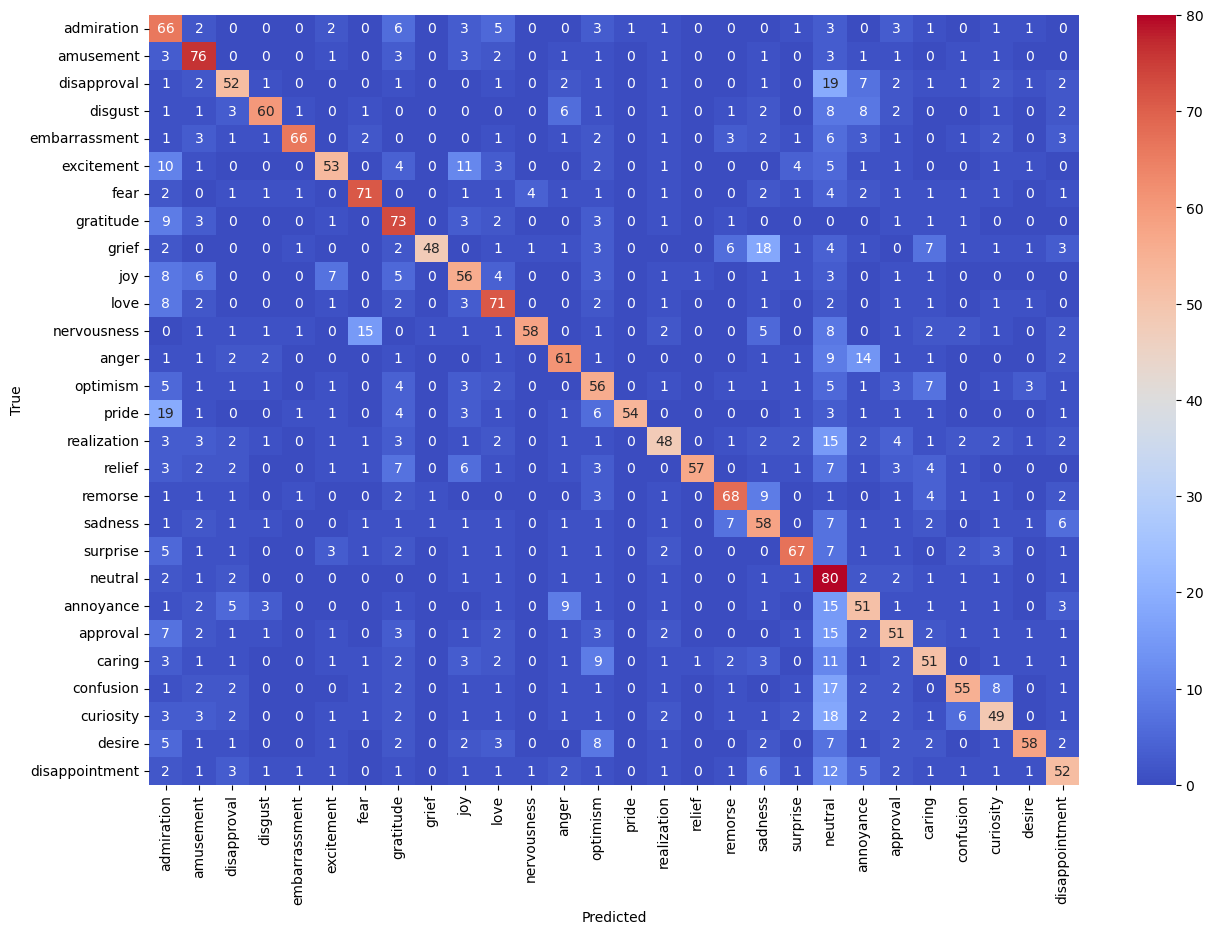

Val confusion matrix


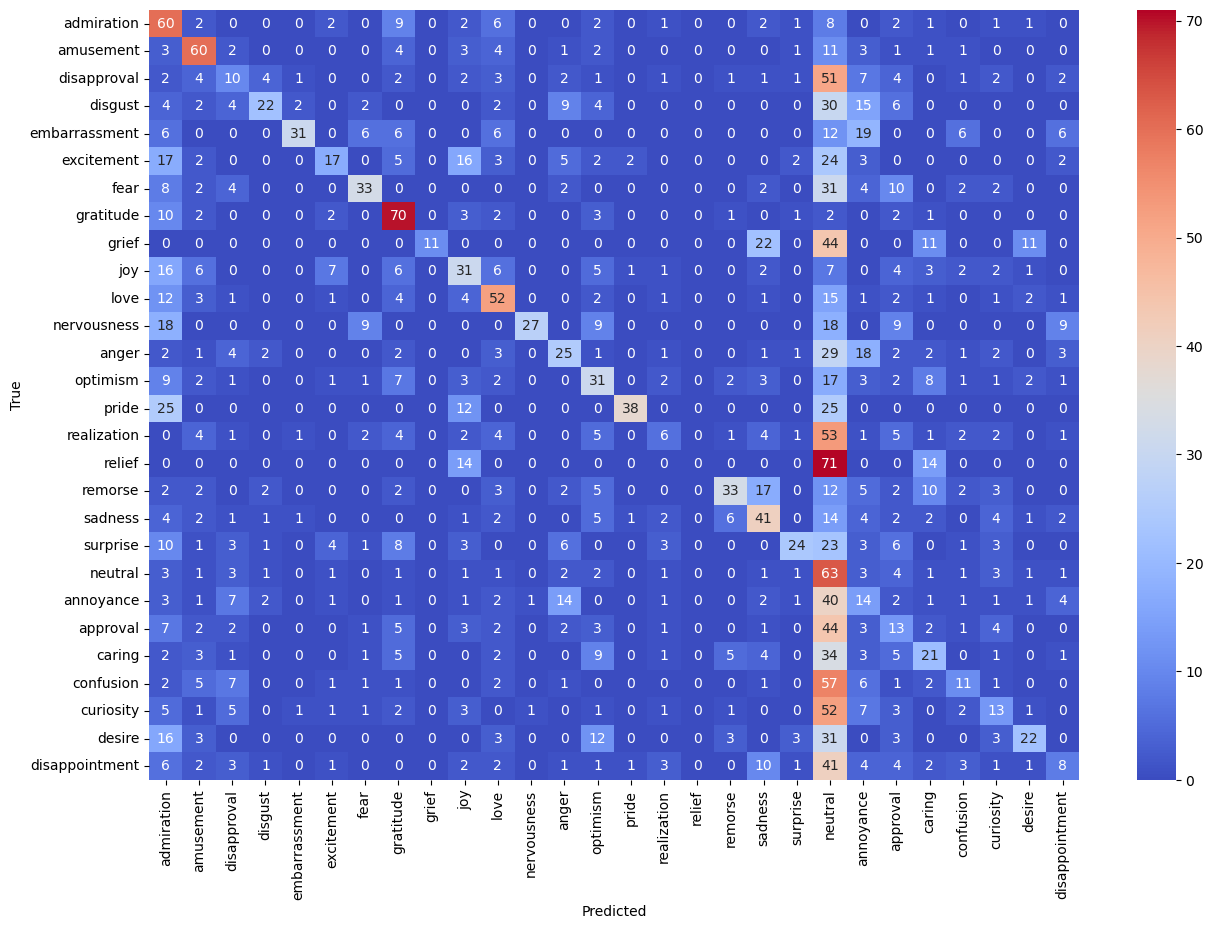

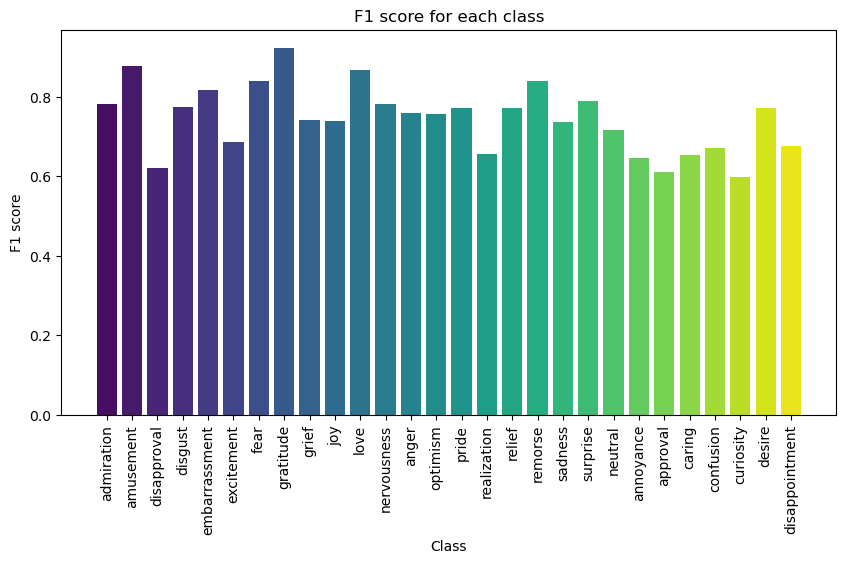

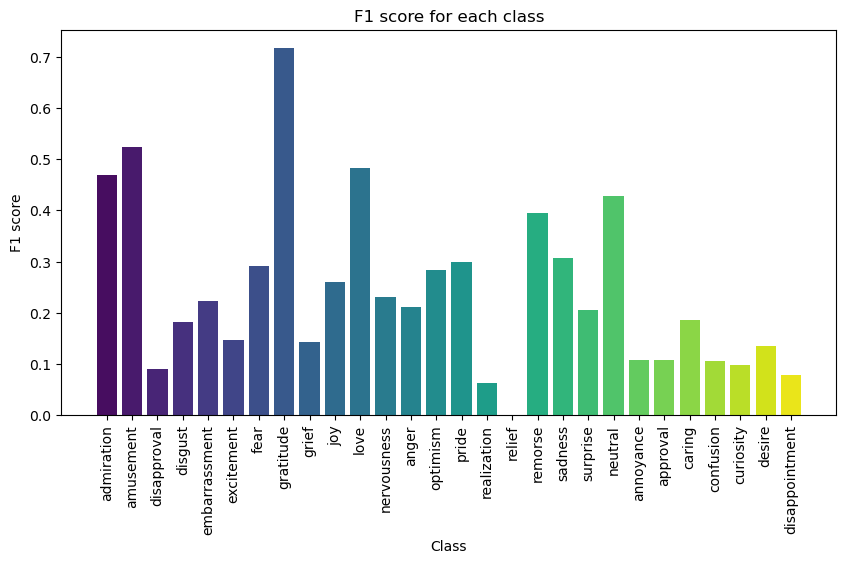

In [11]:
NB_classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', BernoulliNB(alpha=0.01))
]))
bayes_analysis(train_df, val_df, NB_classifier, CLEAN_TEXT_COLUMN, LABELS)

Train metrics
                precision    recall  f1-score   support

    admiration       0.79      0.78      0.79      4130
     amusement       0.88      0.87      0.88      2328
   disapproval       0.73      0.57      0.64      2022
       disgust       0.86      0.72      0.78       793
 embarrassment       0.89      0.78      0.83       303
    excitement       0.69      0.69      0.69       853
          fear       0.90      0.81      0.85       596
     gratitude       0.85      0.93      0.89      2662
         grief       0.73      0.78      0.75        77
           joy       0.76      0.73      0.75      1452
          love       0.88      0.86      0.87      2086
   nervousness       0.87      0.74      0.80       164
         anger       0.82      0.74      0.78      1567
      optimism       0.75      0.74      0.75      1581
         pride       0.87      0.77      0.82       111
   realization       0.77      0.59      0.67      1110
        relief       0.90      0.

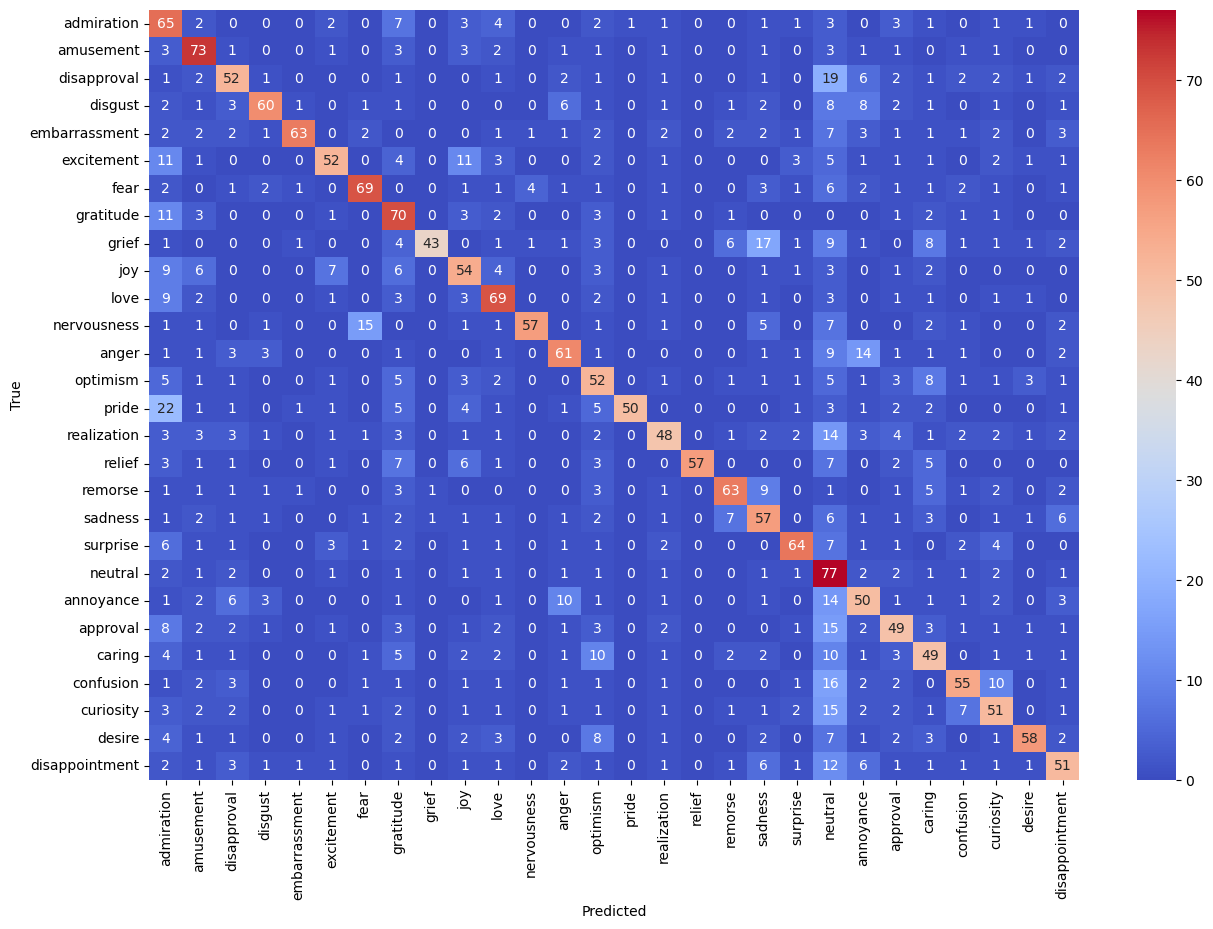

Val confusion matrix


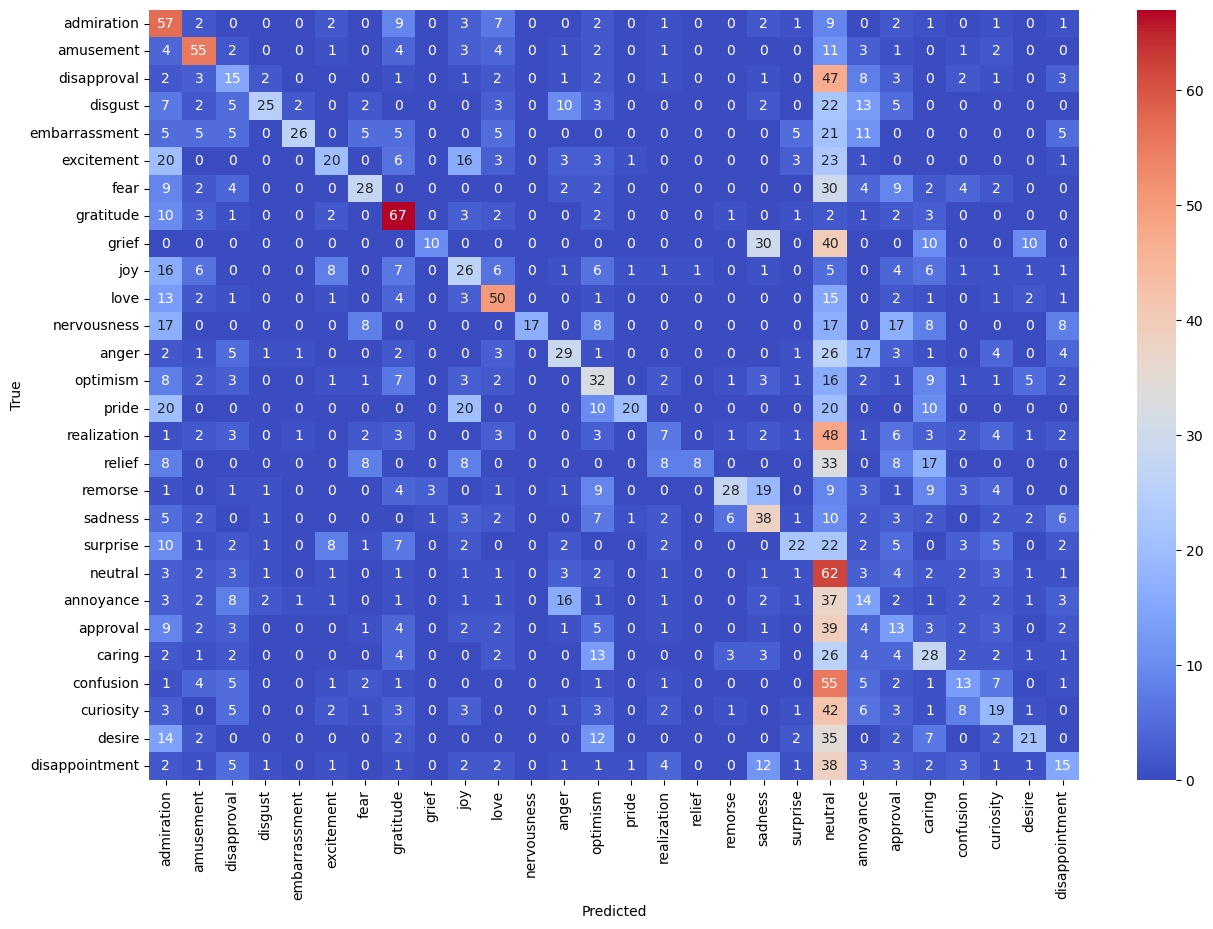

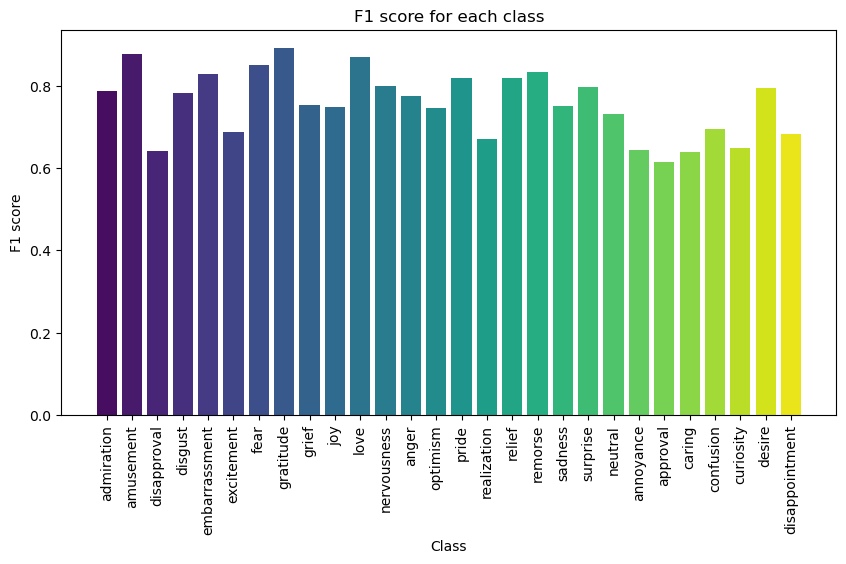

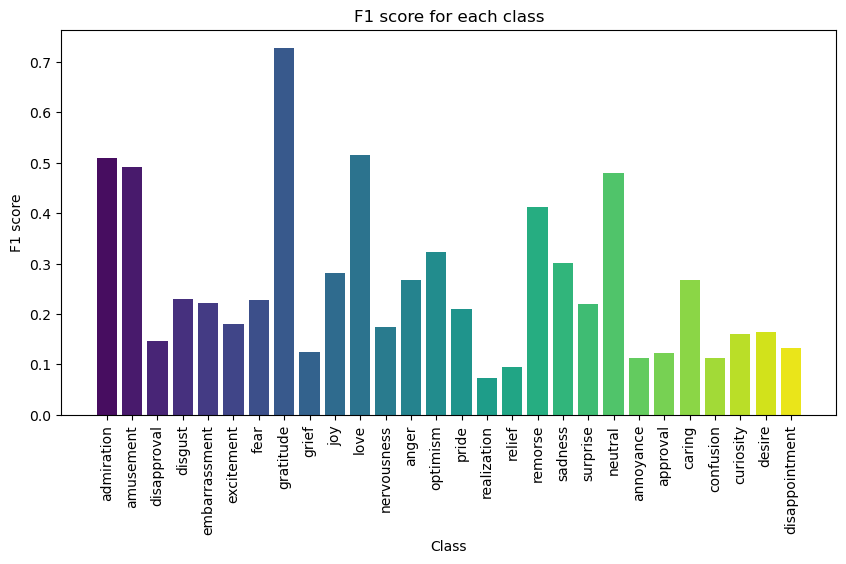

In [10]:
NB_classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', BernoulliNB(alpha=0.01))
]))
bayes_analysis(train_df, val_df, NB_classifier, CLEAN_TEXT_COLUMN, LABELS)

Removing stopwords yealds worse performances

### Feature selection

Attempt with min df

Train metrics
                precision    recall  f1-score   support

    admiration       0.72      0.61      0.66      4130
     amusement       0.84      0.73      0.78      2328
   disapproval       0.46      0.29      0.36      2022
       disgust       0.74      0.51      0.60       793
 embarrassment       0.82      0.66      0.73       303
    excitement       0.56      0.46      0.50       853
          fear       0.83      0.66      0.74       596
     gratitude       0.86      0.88      0.87      2662
         grief       0.67      0.78      0.72        77
           joy       0.67      0.55      0.61      1452
          love       0.83      0.76      0.80      2086
   nervousness       0.81      0.69      0.74       164
         anger       0.67      0.47      0.55      1567
      optimism       0.61      0.57      0.59      1581
         pride       0.81      0.72      0.76       111
   realization       0.54      0.35      0.42      1110
        relief       0.76      0.

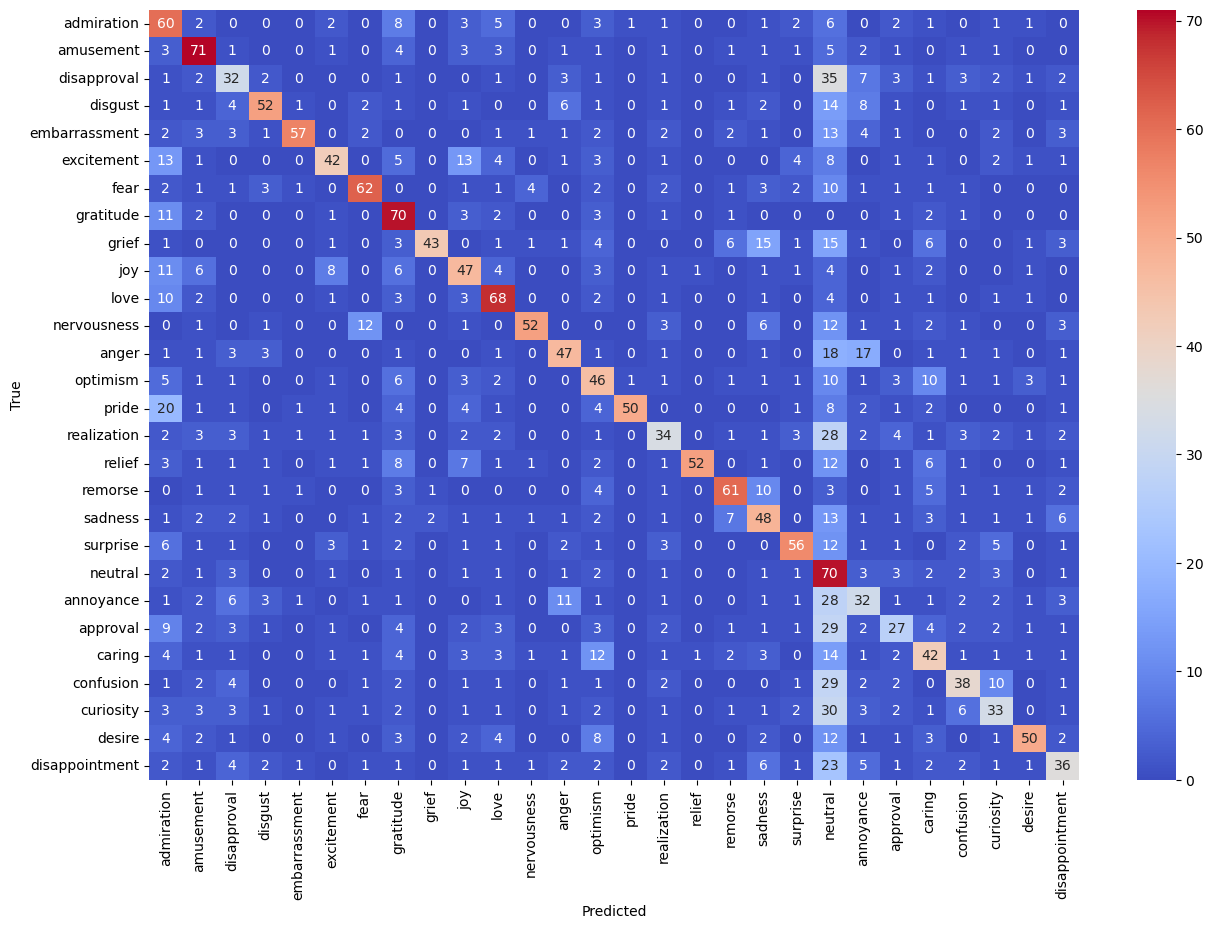

Val confusion matrix


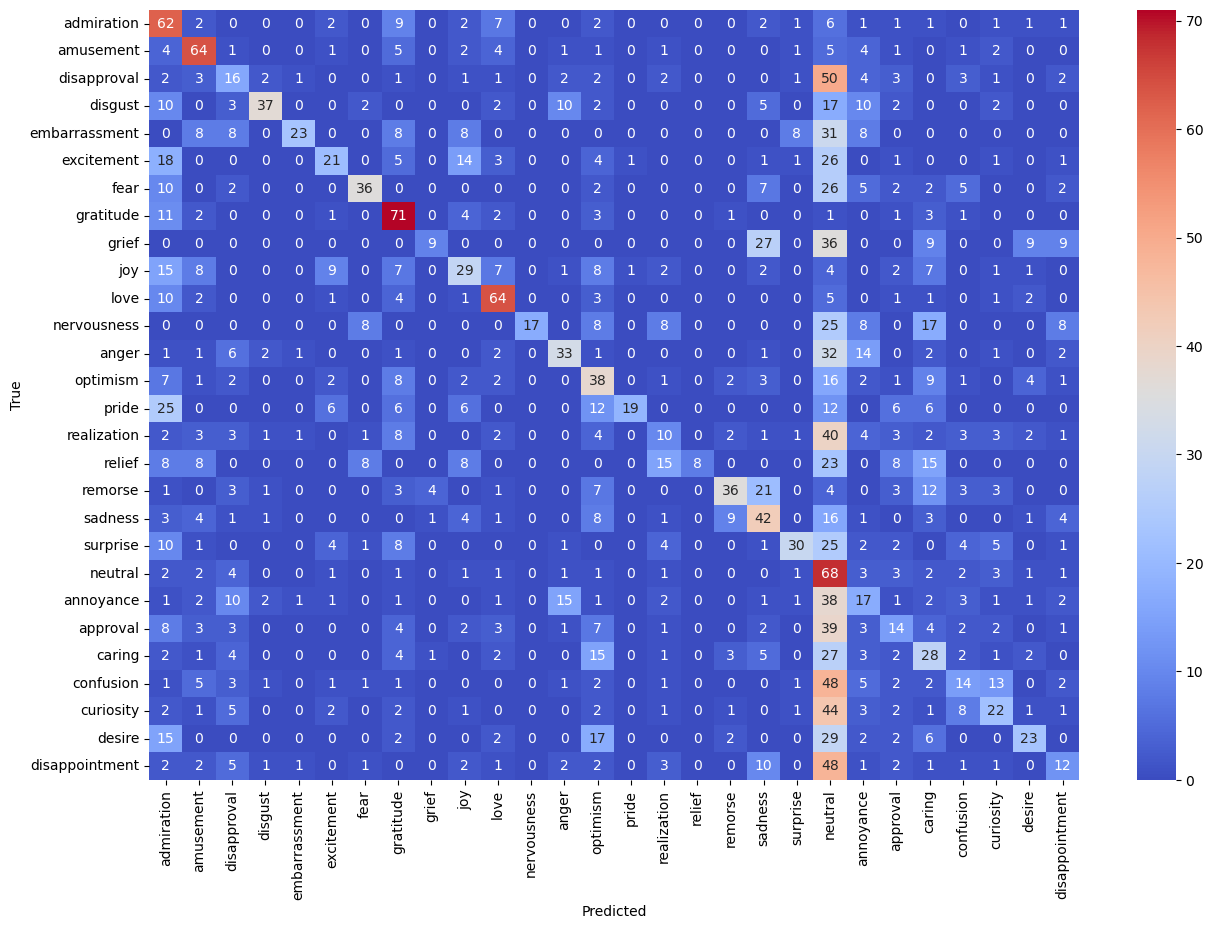

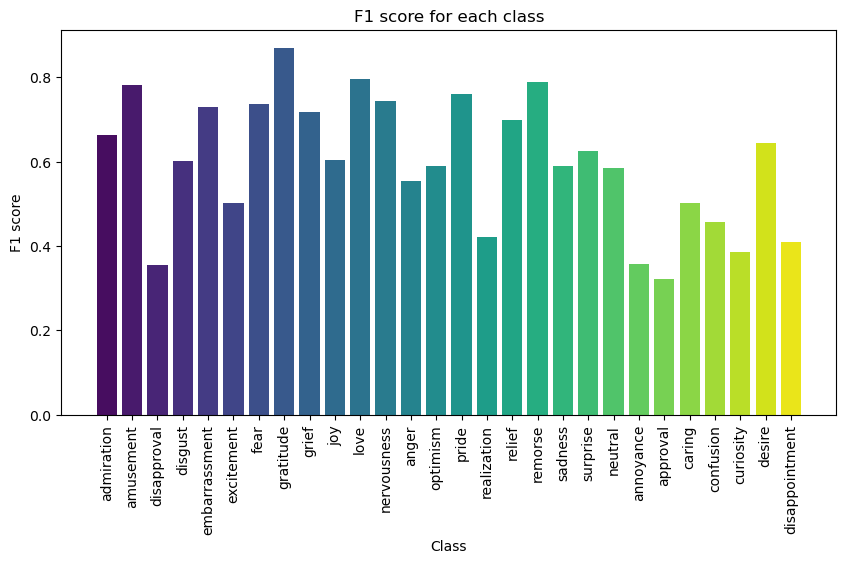

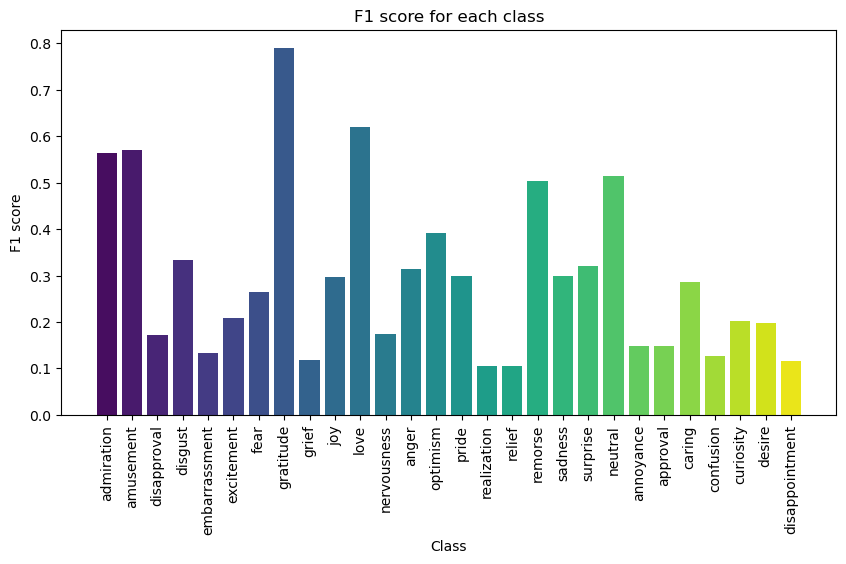

In [12]:
# training one versus rest classifier
classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer(min_df=10)),
    ('clf', BernoulliNB(alpha=0.01))
]))

bayes_analysis(train_df, val_df, classifier, CLEAN_TEXT_COLUMN, LABELS)

Attempt also with pmi based feature selection

Train metrics
                precision    recall  f1-score   support

    admiration       0.75      0.57      0.65      4130
     amusement       0.84      0.71      0.77      2328
   disapproval       0.44      0.25      0.32      2022
       disgust       0.71      0.44      0.55       793
 embarrassment       0.78      0.58      0.67       303
    excitement       0.57      0.39      0.46       853
          fear       0.79      0.61      0.69       596
     gratitude       0.89      0.88      0.88      2662
         grief       0.68      0.77      0.72        77
           joy       0.65      0.48      0.55      1452
          love       0.82      0.74      0.78      2086
   nervousness       0.71      0.66      0.68       164
         anger       0.67      0.41      0.51      1567
      optimism       0.60      0.54      0.57      1581
         pride       0.85      0.74      0.79       111
   realization       0.51      0.31      0.39      1110
        relief       0.82      0.

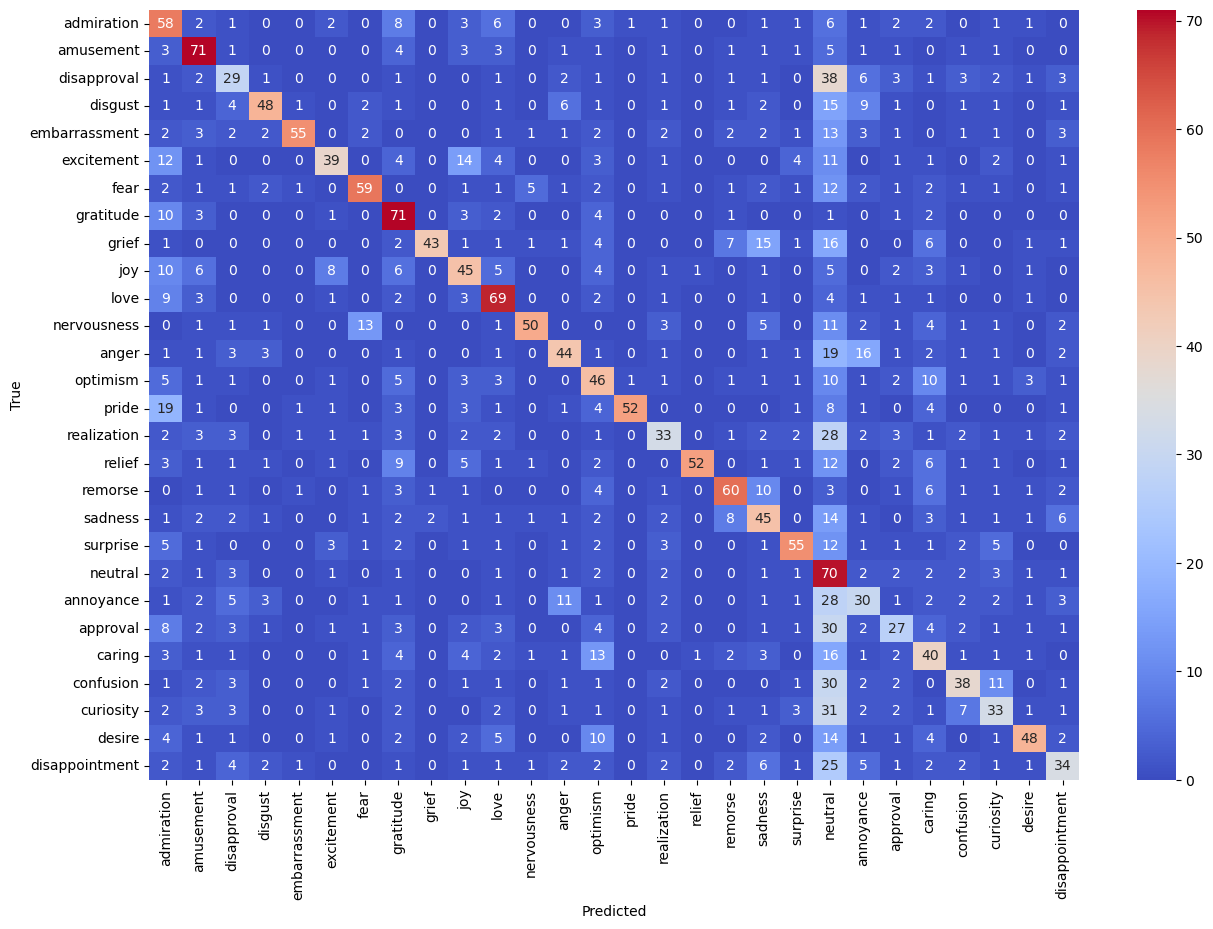

Val confusion matrix


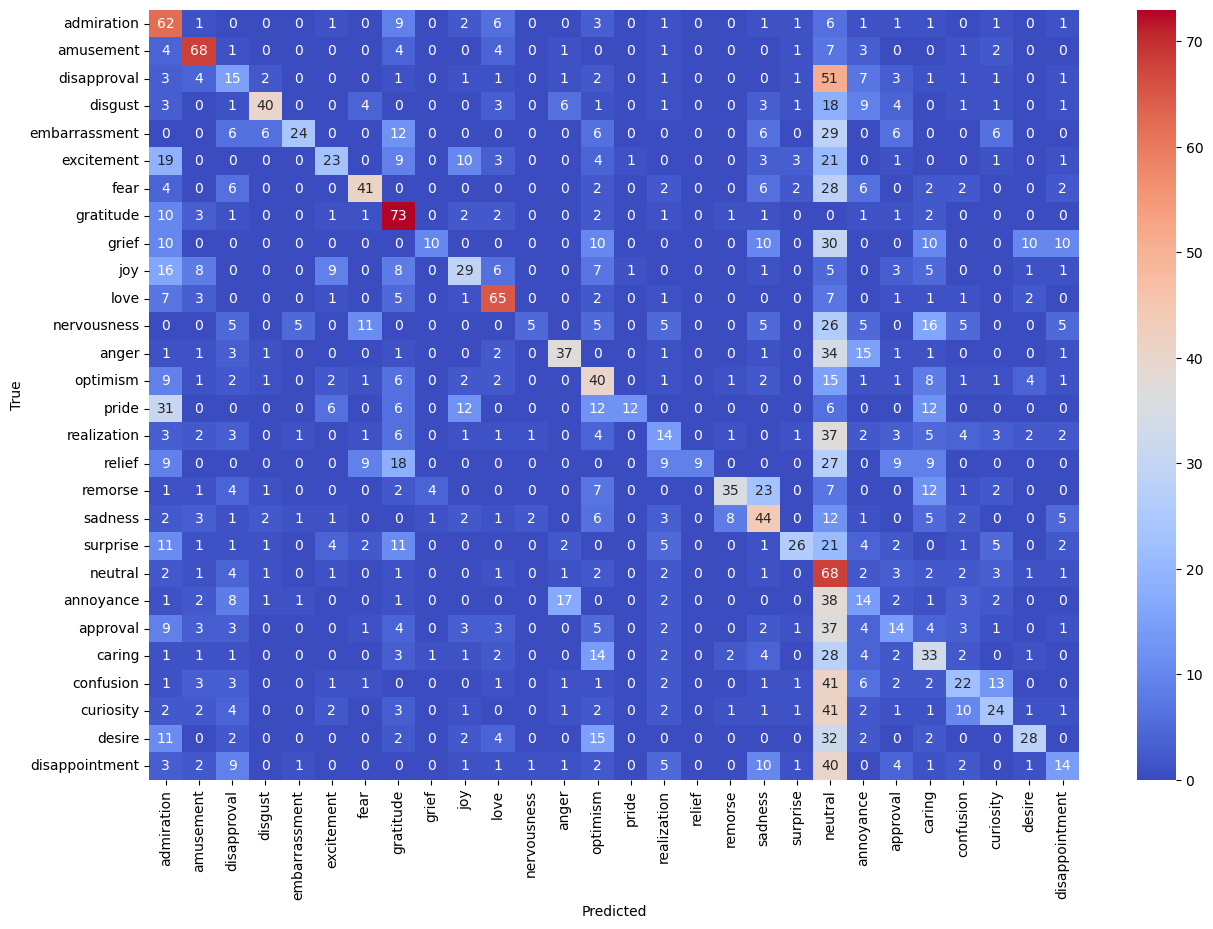

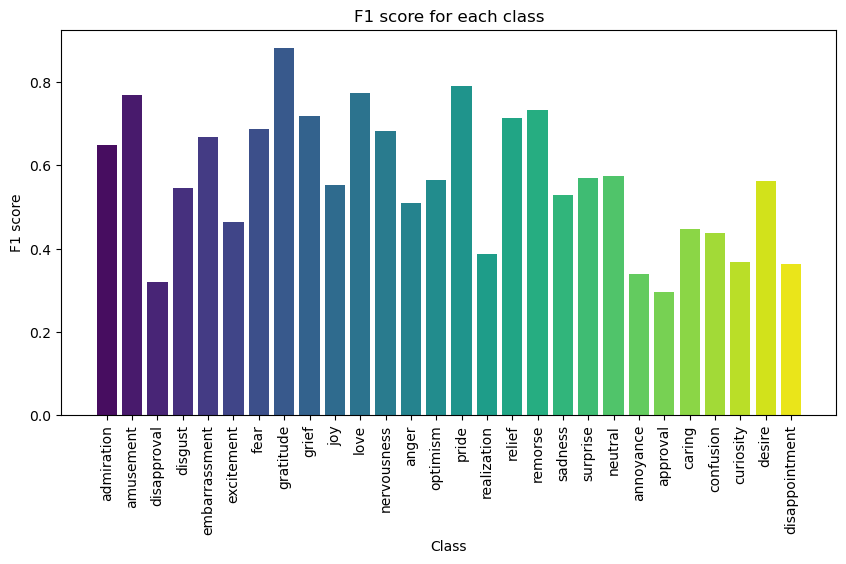

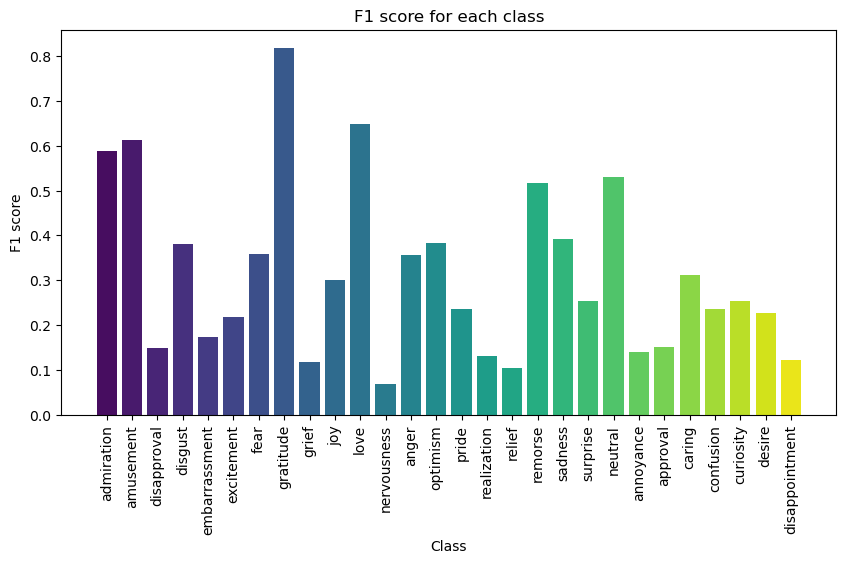

In [9]:
# training one versus rest classifier
classifier = OneVsRestClassifier(Pipeline([
    ('vect', CountVectorizer(min_df=5)),
    ('select', SelectKBest(mutual_info_classif, k=1000)),
    ('tfidf', TfidfTransformer()),
    ('clf', BernoulliNB(alpha=0.01))
]))

bayes_analysis(train_df, val_df, classifier, CLEAN_TEXT_COLUMN, LABELS)

Train metrics
                precision    recall  f1-score   support

    admiration       0.81      0.63      0.71      4130
     amusement       0.87      0.76      0.81      2328
   disapproval       0.64      0.44      0.52      2022
       disgust       0.79      0.62      0.69       793
 embarrassment       0.89      0.73      0.80       303
    excitement       0.70      0.58      0.63       853
          fear       0.86      0.71      0.78       596
     gratitude       0.89      0.90      0.90      2662
         grief       0.76      0.84      0.80        77
           joy       0.73      0.59      0.65      1452
          love       0.85      0.79      0.82      2086
   nervousness       0.86      0.74      0.79       164
         anger       0.79      0.57      0.66      1567
      optimism       0.69      0.64      0.66      1581
         pride       0.85      0.79      0.82       111
   realization       0.69      0.50      0.58      1110
        relief       0.86      0.

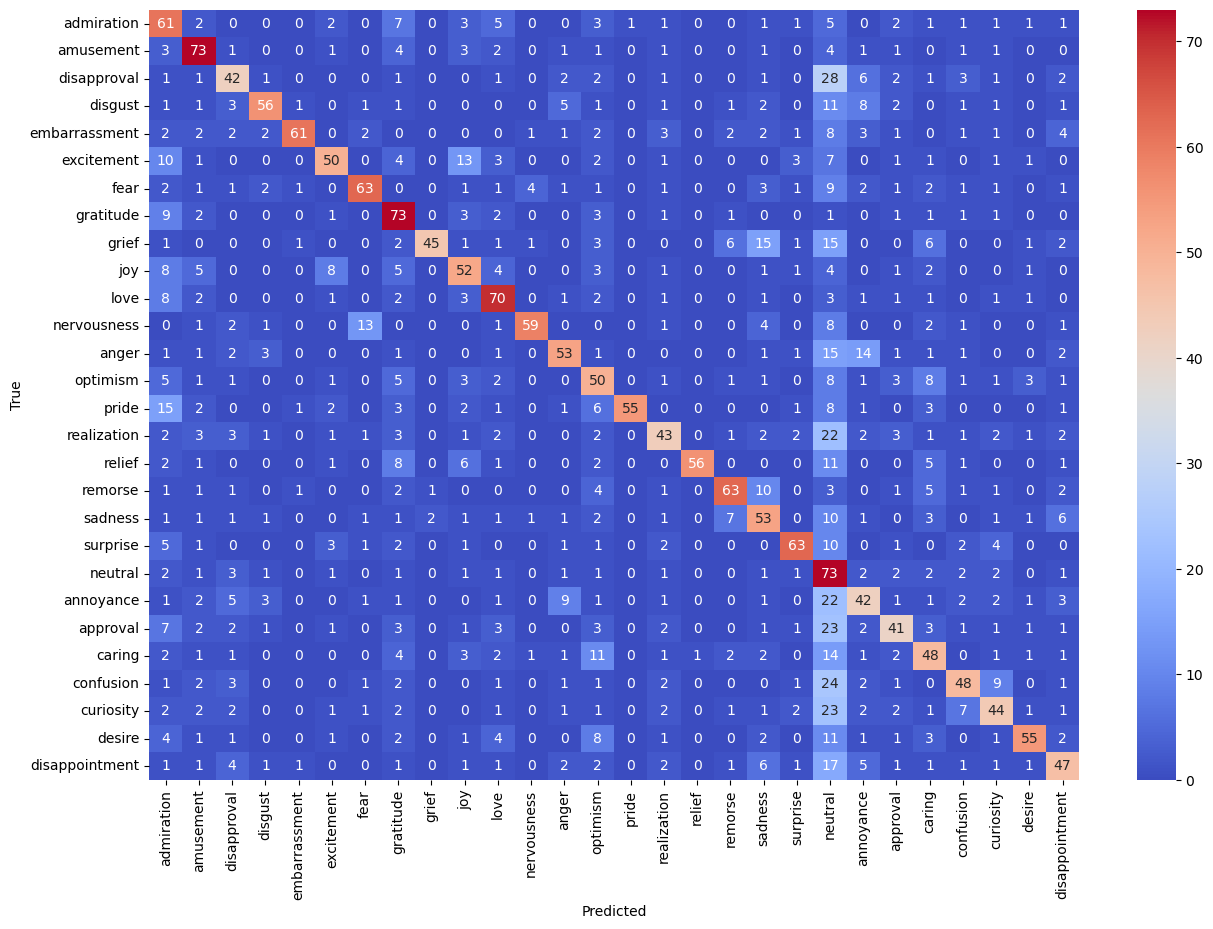

Val confusion matrix


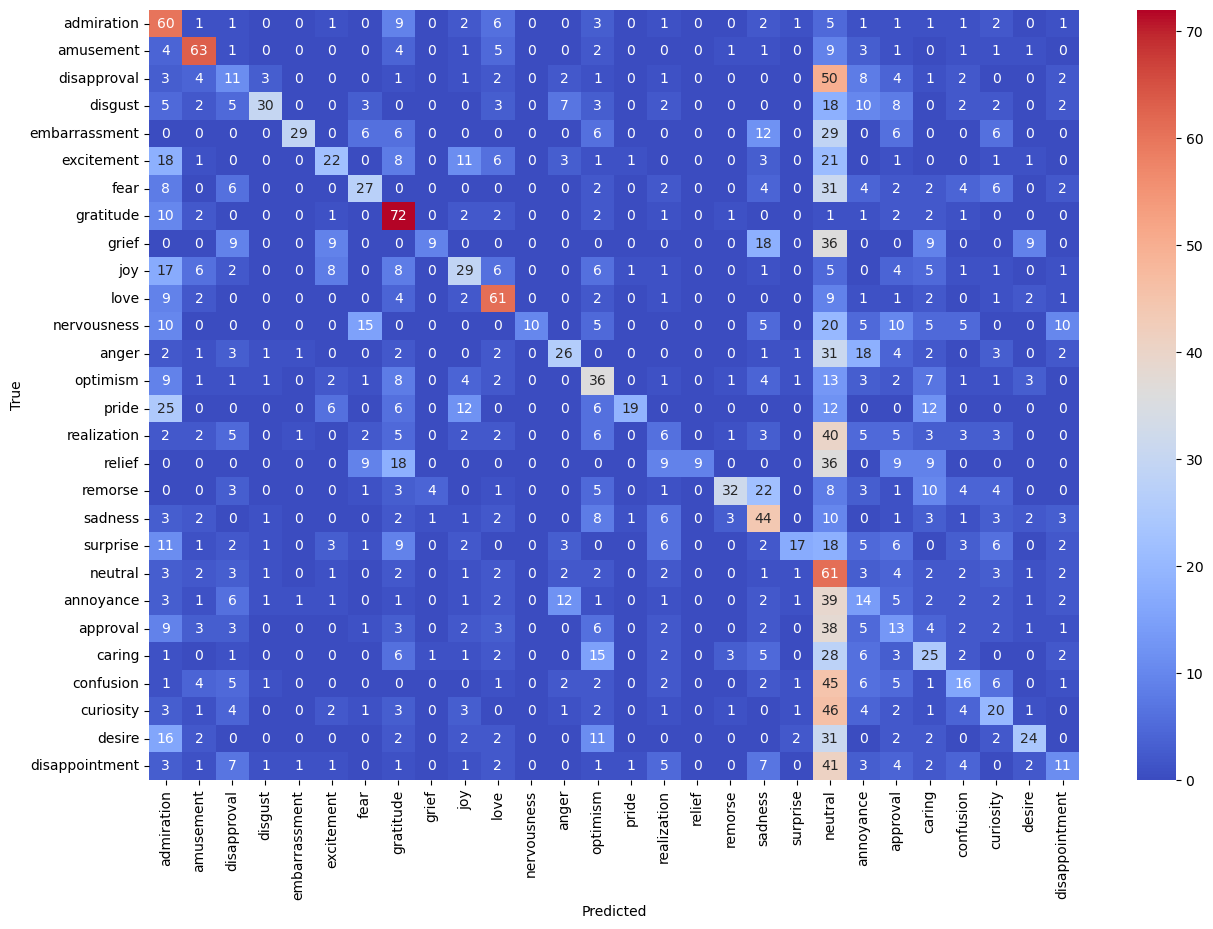

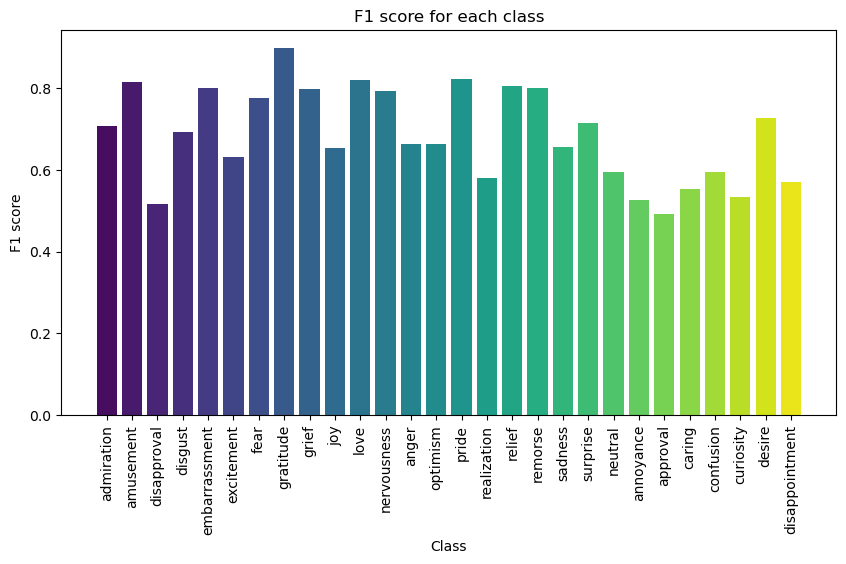

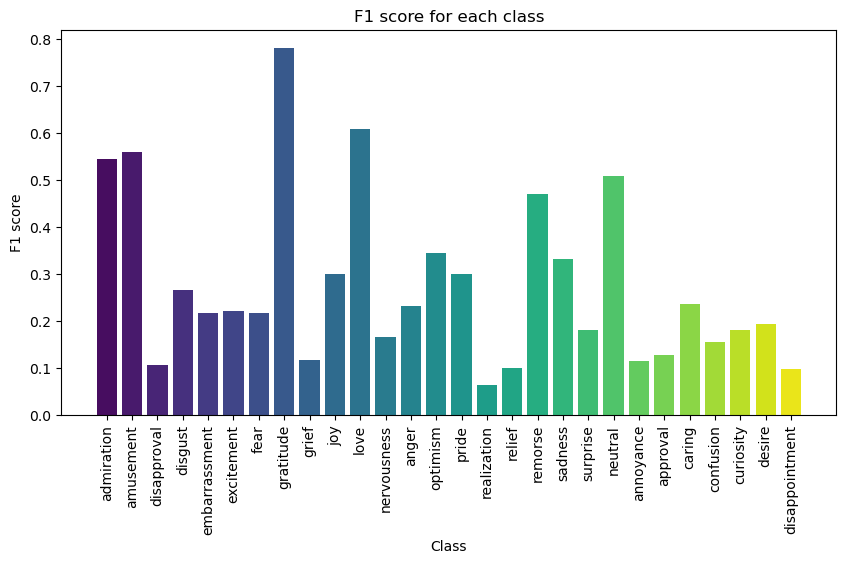

In [14]:
# training one versus rest classifier
classifier = OneVsRestClassifier(Pipeline([
    ('vect', CountVectorizer()),
    ('select', SelectKBest(mutual_info_classif, k=2000)),
    ('tfidf', TfidfTransformer()),
    ('clf', BernoulliNB(alpha=0.01))
]))

bayes_analysis(train_df, val_df, classifier, CLEAN_TEXT_COLUMN, LABELS)

### Trying best on raw data to check for cleaning usefulness

In [15]:
# load raw dataset
raw_train_df, raw_val_df, raw_test_df = load_dataset(DatasetEnum.GoEmotions, k_hot_encode=True)

Train metrics
                precision    recall  f1-score   support

    admiration       0.75      0.59      0.66      4130
     amusement       0.84      0.71      0.77      2328
   disapproval       0.45      0.27      0.34      2022
       disgust       0.70      0.48      0.57       793
 embarrassment       0.75      0.62      0.68       303
    excitement       0.58      0.42      0.49       853
          fear       0.77      0.59      0.67       596
     gratitude       0.89      0.88      0.88      2662
         grief       0.71      0.78      0.75        77
           joy       0.65      0.49      0.56      1452
          love       0.82      0.73      0.78      2086
   nervousness       0.75      0.65      0.70       164
         anger       0.67      0.43      0.52      1567
      optimism       0.59      0.54      0.57      1581
         pride       0.85      0.69      0.76       111
   realization       0.47      0.34      0.39      1110
        relief       0.81      0.

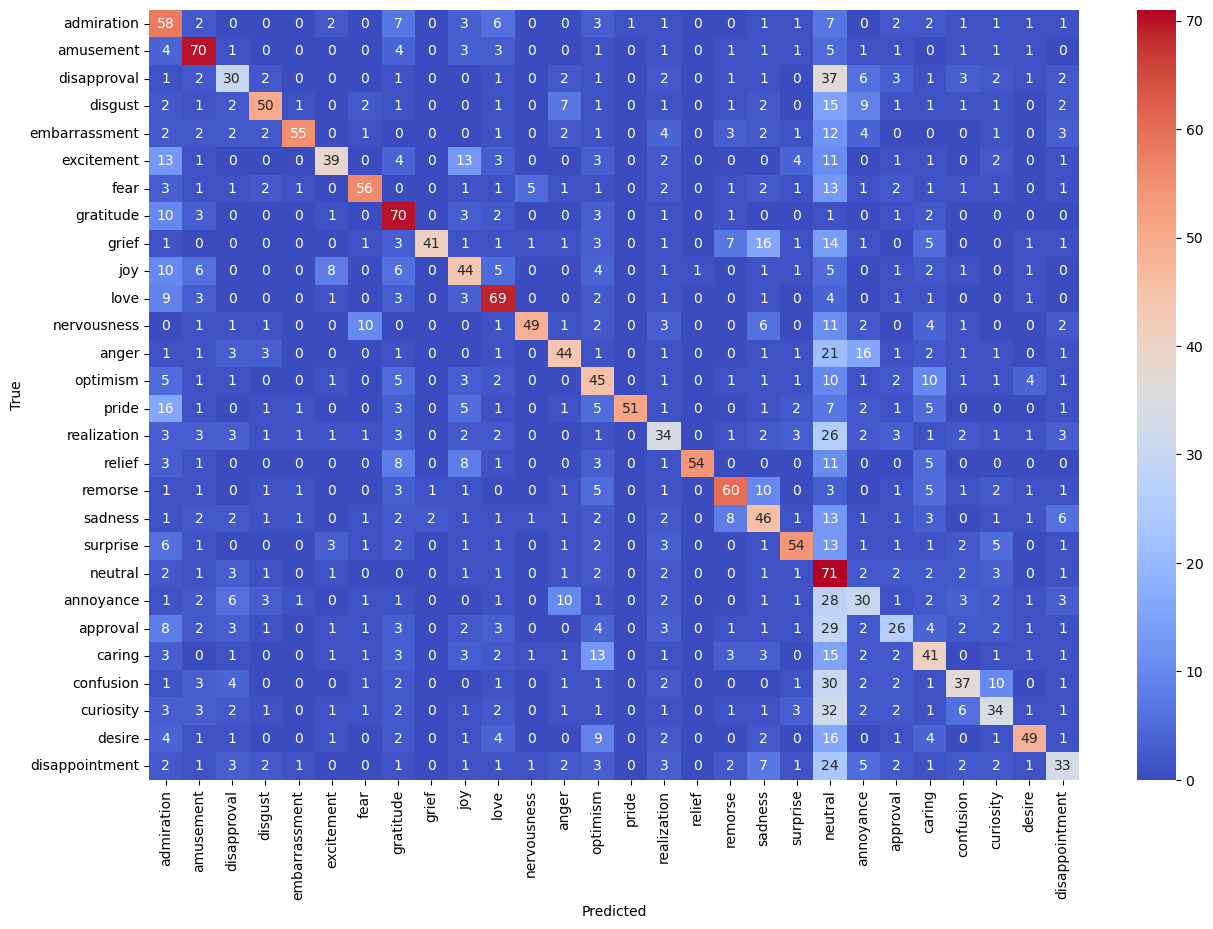

Val confusion matrix


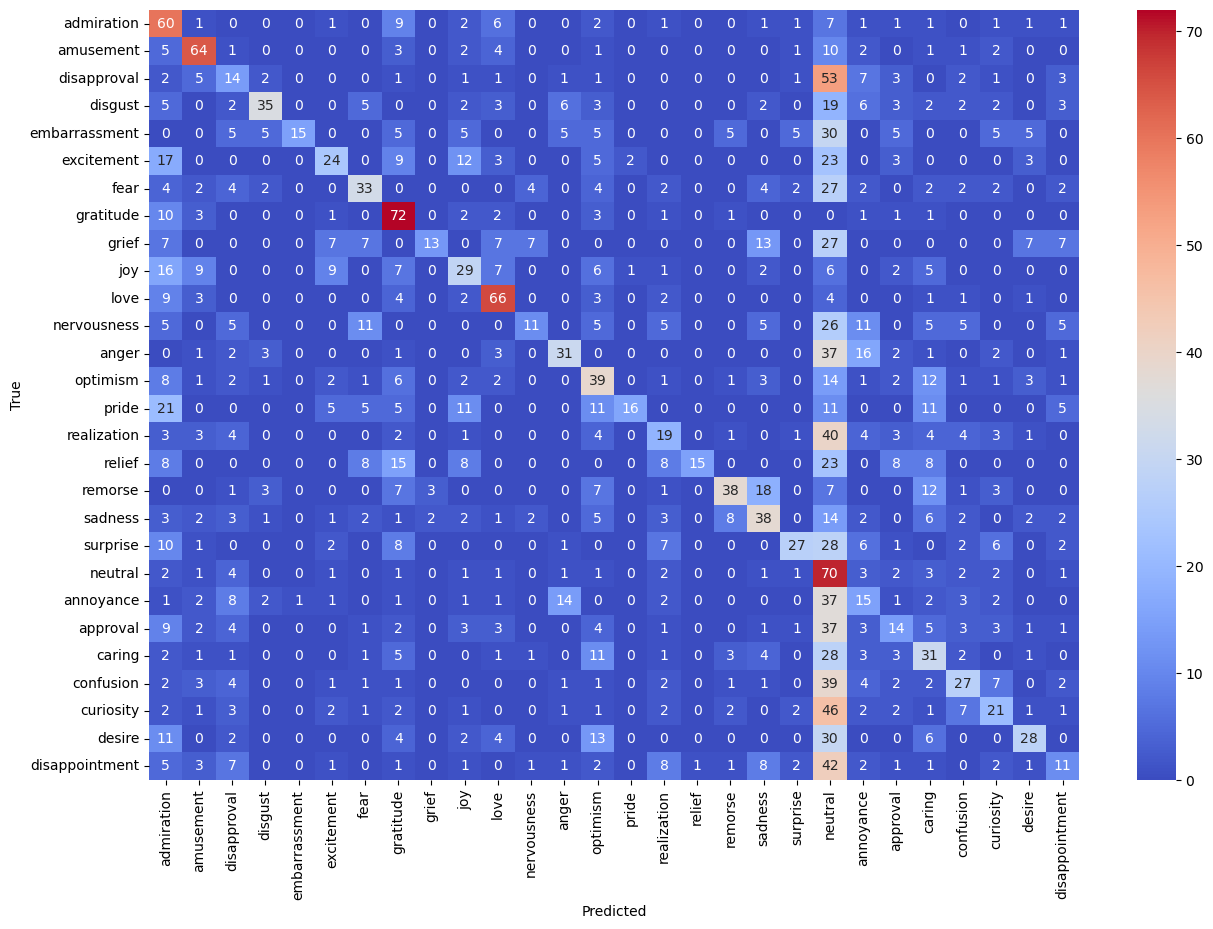

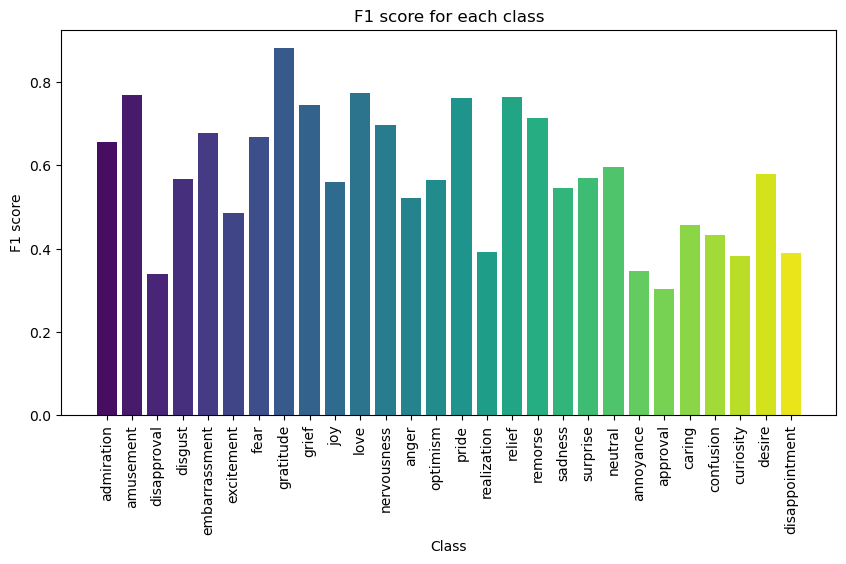

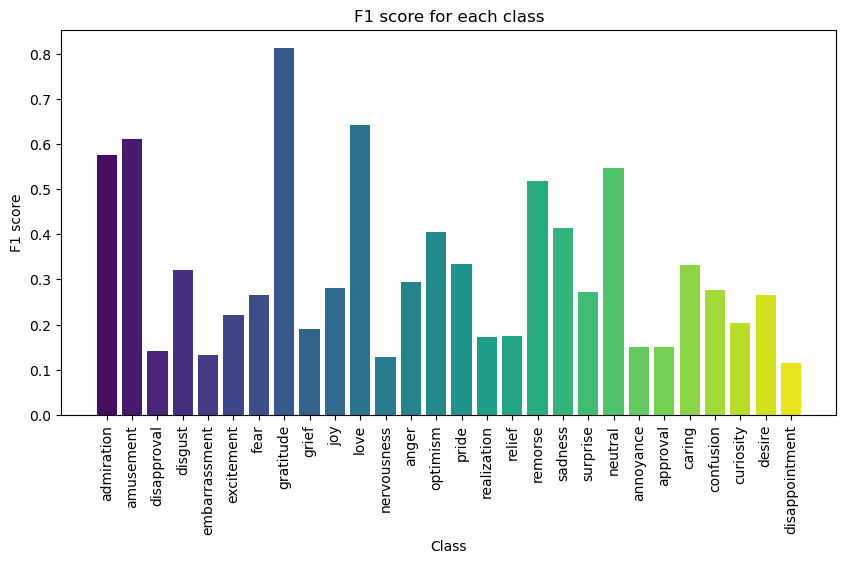

In [16]:
classifier = OneVsRestClassifier(Pipeline([
    ('vect', CountVectorizer(min_df=5)),
    ('select', SelectKBest(mutual_info_classif, k=1000)),
    ('tfidf', TfidfTransformer()),
    ('clf', BernoulliNB(alpha=0.01))
]))

bayes_analysis(raw_train_df, raw_val_df, classifier, TEXT_COLUMN, LABELS)

# Saving best models and test

In [10]:
CLASSIFIER_PATH = './checkpoints/GoEmotions/'
if not os.path.exists(CLASSIFIER_PATH):
    os.makedirs(CLASSIFIER_PATH)
NB_CLASSIFIER_PATH = CLASSIFIER_PATH + 'nb_classifier.pkl'

Train metrics
                precision    recall  f1-score   support

    admiration       0.75      0.57      0.65      4130
     amusement       0.84      0.71      0.77      2328
   disapproval       0.44      0.25      0.32      2022
       disgust       0.71      0.44      0.55       793
 embarrassment       0.78      0.58      0.67       303
    excitement       0.57      0.39      0.46       853
          fear       0.79      0.61      0.69       596
     gratitude       0.89      0.88      0.88      2662
         grief       0.68      0.77      0.72        77
           joy       0.65      0.48      0.55      1452
          love       0.82      0.74      0.78      2086
   nervousness       0.71      0.66      0.68       164
         anger       0.67      0.41      0.51      1567
      optimism       0.60      0.54      0.57      1581
         pride       0.85      0.74      0.79       111
   realization       0.51      0.31      0.39      1110
        relief       0.82      0.

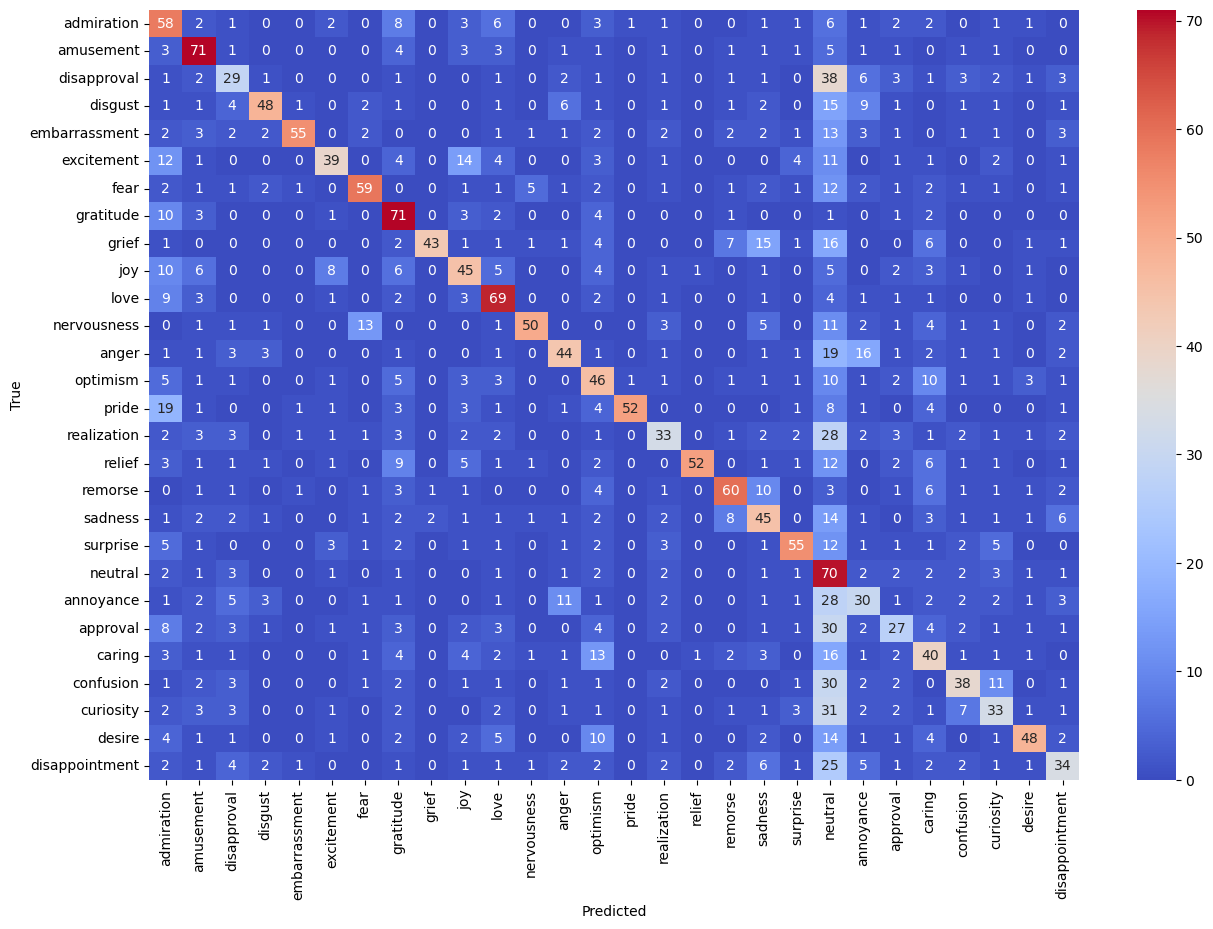

Val confusion matrix


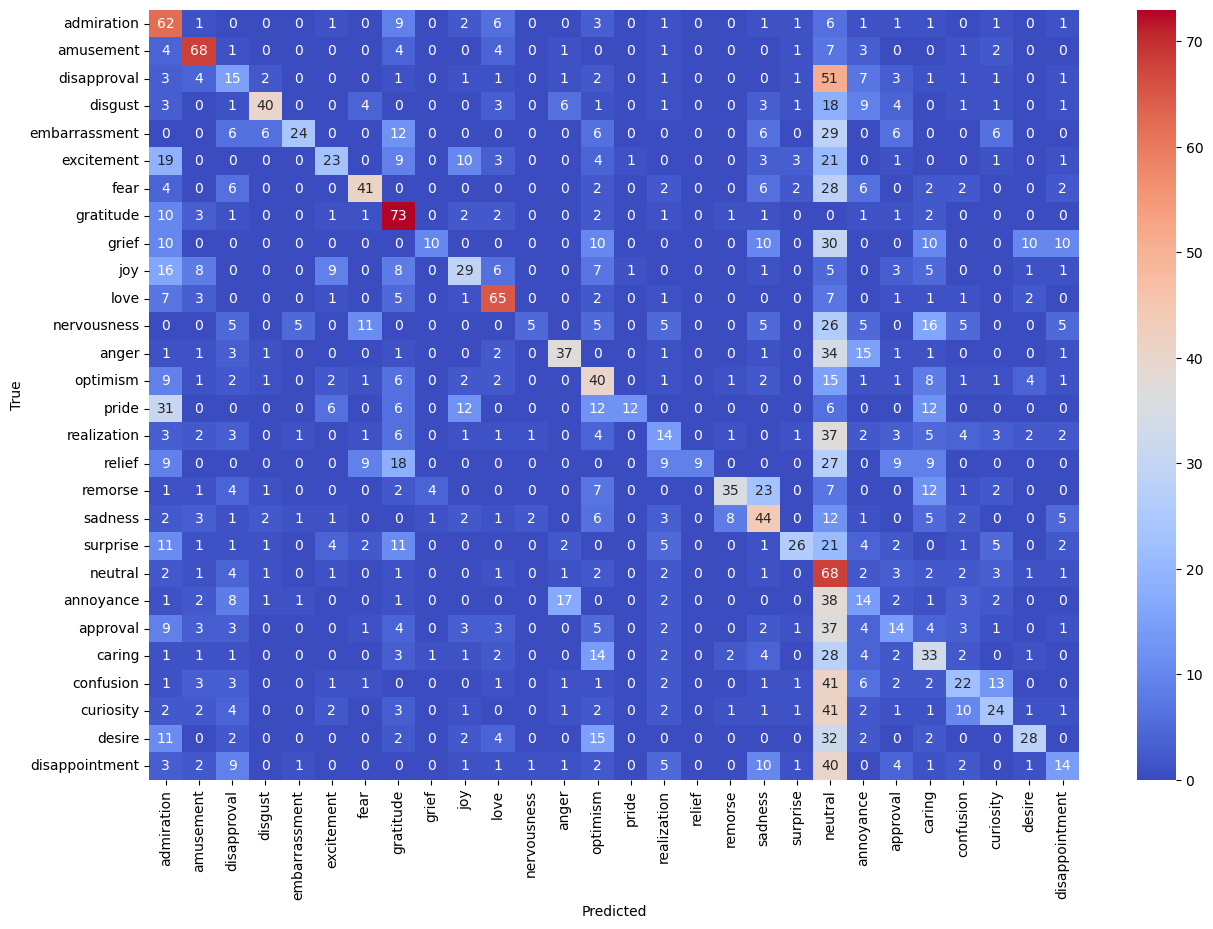

Test metrics
                precision    recall  f1-score   support

    admiration       0.67      0.44      0.53       504
     amusement       0.78      0.50      0.61       264
   disapproval       0.25      0.12      0.16       267
       disgust       0.66      0.22      0.33       123
 embarrassment       0.18      0.05      0.08        37
    excitement       0.30      0.16      0.21       103
          fear       0.64      0.23      0.34        78
     gratitude       0.87      0.78      0.82       352
         grief       0.00      0.00      0.00         6
           joy       0.59      0.36      0.45       161
          love       0.76      0.59      0.66       238
   nervousness       0.20      0.04      0.07        23
         anger       0.48      0.24      0.32       198
      optimism       0.54      0.38      0.45       186
         pride       0.17      0.06      0.09        16
   realization       0.38      0.14      0.21       145
        relief       0.00      0.0

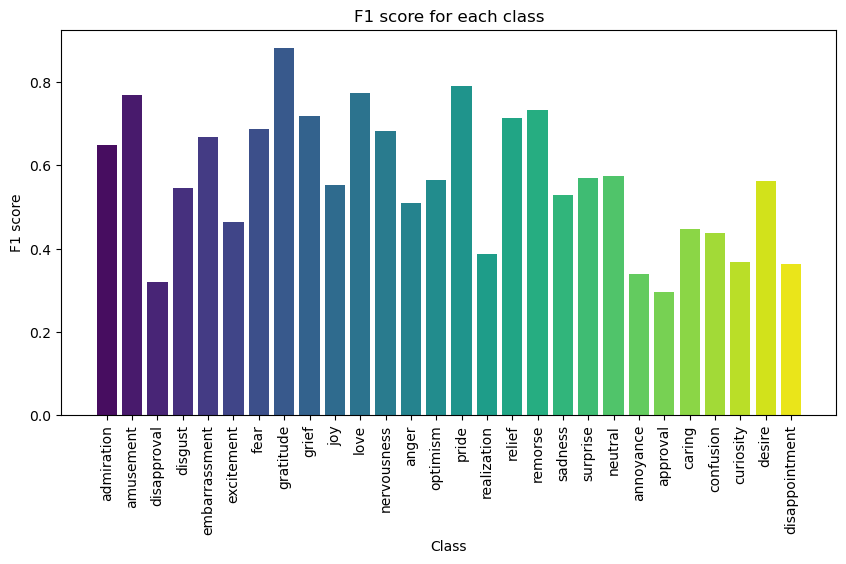

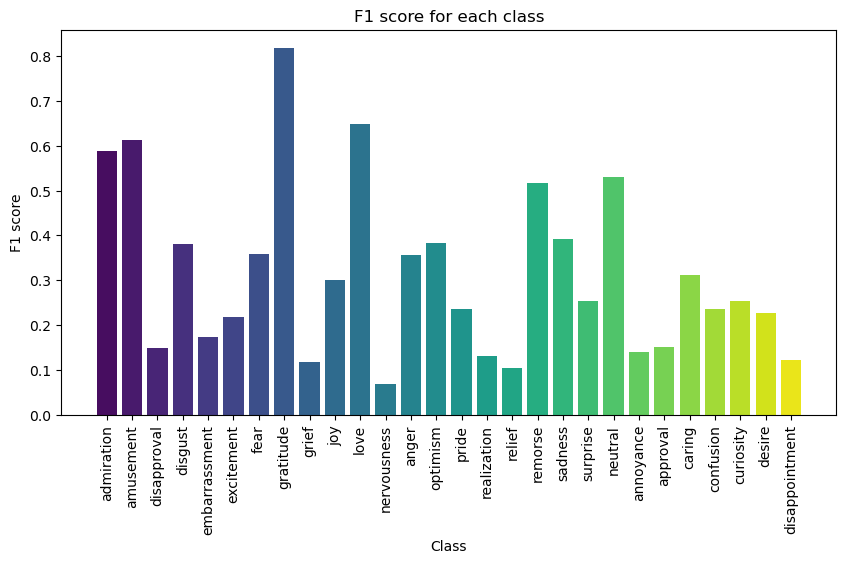

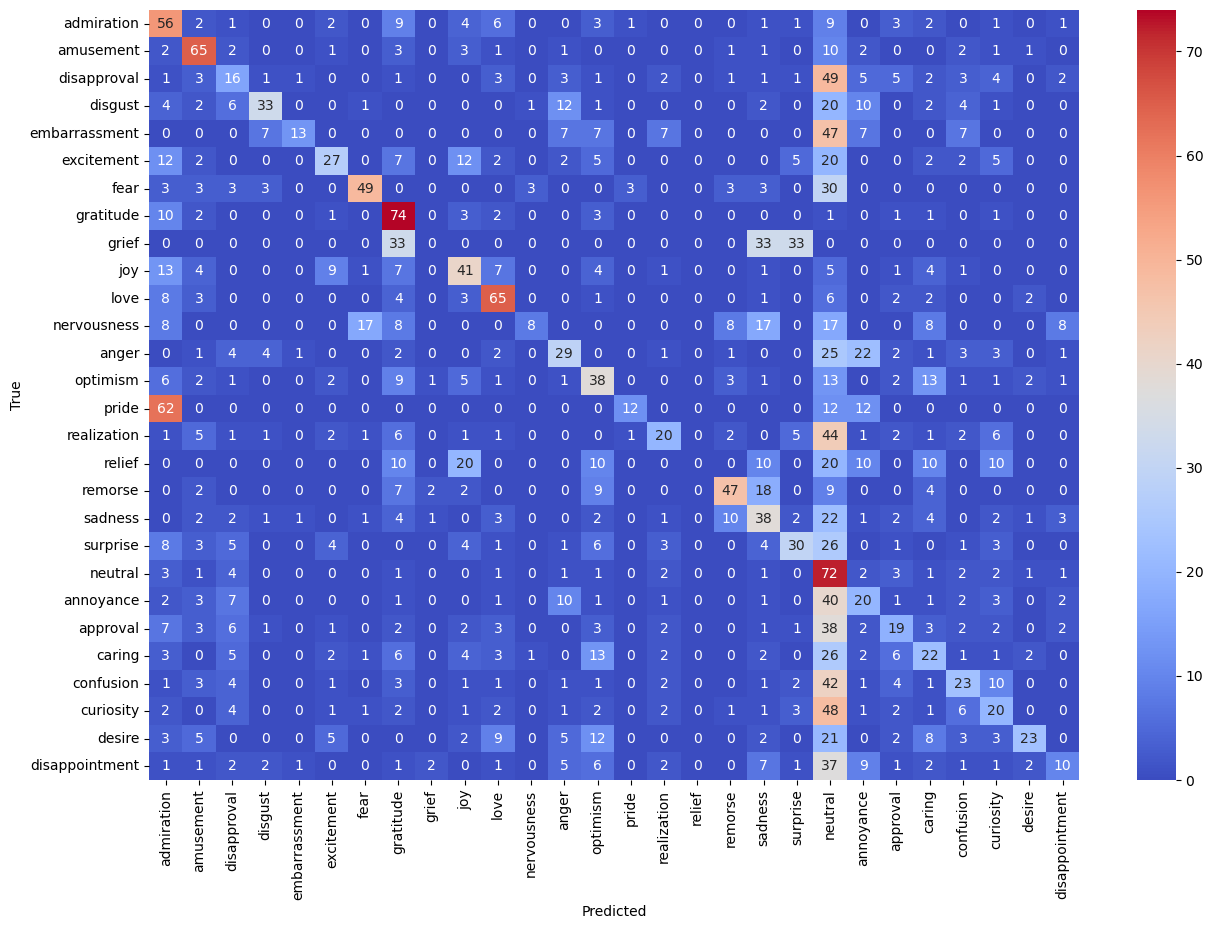

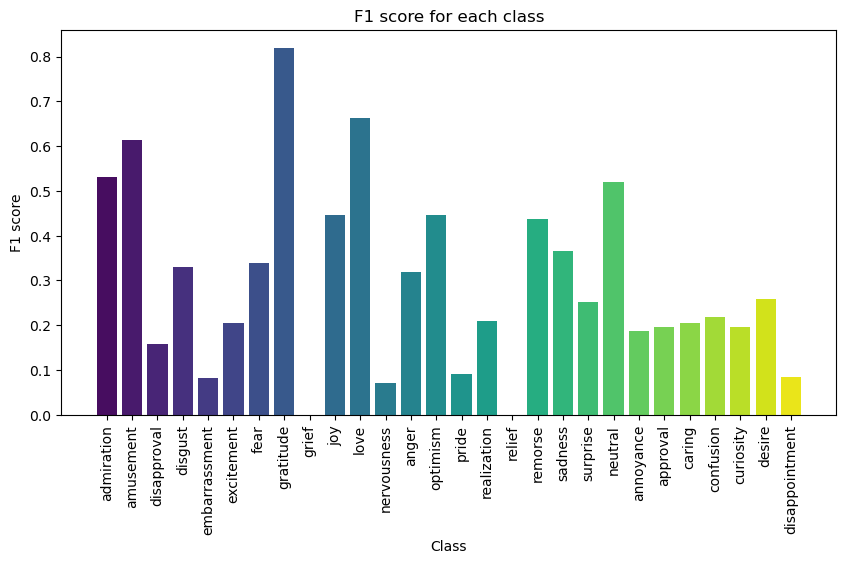

In [11]:
classifier = OneVsRestClassifier(Pipeline([
    ('vect', CountVectorizer(min_df=5)),
    ('select', SelectKBest(mutual_info_classif, k=1000)),
    ('tfidf', TfidfTransformer()),
    ('clf', BernoulliNB(alpha=0.01))
]))

bayes_analysis(train_df, val_df, classifier, CLEAN_TEXT_COLUMN, LABELS)

# prediction on test
predictions_test = classifier.predict(test_df[CLEAN_TEXT_COLUMN])
# calculate metrics
print("Test metrics")
print(classification_report(test_df[LABELS], predictions_test, target_names=LABELS, zero_division=0))
# plot confusion matrix
print("Test confusion matrix")
plot_multilabel_confusion_heatmap(test_df[LABELS].to_numpy(), predictions_test, LABELS, LABELS, normalize=True)
# bar plot over classes
plot_score_barplot(test_df[LABELS], predictions_test, LABELS)

# save classifier
with open(NB_CLASSIFIER_PATH, 'wb') as f:
    pickle.dump(classifier, f)